In [32]:
import bz2
import pickle
import _pickle as cPickle
import numpy as np
import pylab as pl
from PIL import Image
from nats_bench.api_utils import pickle_load
import re
import os
import matplotlib.pyplot as plt
import json
import networkx as nx
from pathlib import Path
import pandas as pd


# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='bytes')
    return dict


def get_index_from_name(name):
    pattern = r'@(\d+)'
    m = re.search(pattern, name)
    if m:
        return int(m.group(1))
    else:
        print('Not possible to extract number from', name)
        return None


def get_validation_and_test_acc(current_data, validation_results_arr, test_results_arr):
    for key in current_data:
        if 'valid' in key:
            idx = get_index_from_name(key)
            validation_results_arr[idx] = current_data[key]
        elif 'ori-test' in key:
            idx = get_index_from_name(key)
            test_results_arr[idx] = current_data[key]
        else:
            print(f'Following key was missing:', key)


def get_train_acc(current_data, train_result_arr):
    for key in current_data:
        ind = int(key)
        train_result_arr[ind] = current_data[key]


def get_max_value_and_index(np_arr):
    max_val_value = np.amax(np_arr, axis=None, out=None)
    max_val_idx = np.where(np_arr == max_val_value)[0][0] # The first index with the highest value is selected. If the whole list is wanted, delete the last [0]
    return max_val_value, max_val_idx


def get_dict_for_one_architecture(data):
    data_dict = {}
    for number_epochs_str in data:
        for dataset_name_and_seed in data[number_epochs_str]['all_results']:
            dataset_name, seed = dataset_name_and_seed
            if dataset_name.endswith('-valid'):
                clear_dataset_name = dataset_name[:-6]
            else:
                clear_dataset_name = dataset_name
            if not clear_dataset_name in data_dict:
                data_dict[clear_dataset_name] = {}
            if not number_epochs_str in data_dict[clear_dataset_name]:
                data_dict[clear_dataset_name][number_epochs_str] = {}
            data_dict[clear_dataset_name][number_epochs_str][str(seed)] = {}
            number_epochs = int(number_epochs_str)
            # get @1 and @5 accuracies
            validation_acc1es = np.zeros(number_epochs)
            test_acc1es = np.zeros(number_epochs)
            train_acc1es = np.zeros(number_epochs)
            validation_acc5es = np.zeros(number_epochs)
            test_acc5es = np.zeros(number_epochs)
            train_acc5es = np.zeros(number_epochs)
            eval = 'eval_acc1es'
            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed][eval]
            get_validation_and_test_acc(current_data, validation_acc1es, test_acc1es)
            eval = 'eval_acc5es'
            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed][eval]
            get_validation_and_test_acc(current_data, validation_acc5es, test_acc5es)

            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed]['train_acc1es']
            get_train_acc(current_data, train_acc1es)
            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed]['train_acc5es']
            get_train_acc(current_data, train_acc5es)
            # save accuracies in the dict
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['val_acc1es'] = validation_acc1es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['val_acc5es'] = validation_acc5es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['test_acc1es'] = test_acc1es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['test_acc5es'] = test_acc5es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['train_acc1es'] = train_acc1es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['train_acc5es'] = train_acc5es
            # save all additional information in the dict
            if 'additional_information' not in data_dict[clear_dataset_name][number_epochs_str]:
                data_dict[clear_dataset_name][number_epochs_str]['additional_information'] = {}
                for add_info in data[number_epochs_str]:
                    if add_info != 'all_results':
                        data_dict[clear_dataset_name][number_epochs_str]['additional_information'][add_info] = data[number_epochs_str][add_info]
                for add_info in data[number_epochs_str]['all_results'][dataset_name_and_seed]:
                    if add_info not in ['eval_acc1es', 'eval_acc5es', 'train_acc1es', 'train_acc5es']:
                        data_dict[clear_dataset_name][number_epochs_str]['additional_information'][add_info] = data[number_epochs_str]['all_results'][dataset_name_and_seed][add_info]
    return data_dict


def get_data_from_filepath(path):
    return decompress_pickle(path)


def get_mean_epoch_accs(data_dict, seeds=['777'], epochs='200', dataset='utdmhad'):
    if len(seeds) > 0:
        train_acc1es = np.array(data_dict[dataset][epochs][seeds[0]]['train_acc1es'])
        val_acc1es = np.array(data_dict[dataset][epochs][seeds[0]]['val_acc1es'])
        test_acc1es = np.array(data_dict[dataset][epochs][seeds[0]]['test_acc1es'])
        if len(seeds) > 1:
            for seed in seeds[1:]:
                train_acc1es += np.array(data_dict[dataset][epochs][seed]['train_acc1es'])
                val_acc1es += np.array(data_dict[dataset][epochs][seed]['val_acc1es'])
                test_acc1es += np.array(data_dict[dataset][epochs][seed]['test_acc1es'])
            train_acc1es /= len(seeds)
            val_acc1es /= len(seeds)
            test_acc1es /= len(seeds)
        return train_acc1es, val_acc1es, test_acc1es
    else:
        print('get_mean_epoch_accs: No seeds provided.')
        return [], [], []


def get_max_train_val_test_acc1(data_dict, seed='777', epochs='200', dataset='utdmhad'):
    train_acc1, val_acc1, test_acc1 = get_epoch_accs(data_dict, seed=seed, epochs=epochs, dataset=dataset)
    max_train_acc, max_train_idx = get_max_value_and_index(train_acc1)
    max_val_acc, max_val_idx = get_max_value_and_index(val_acc1)
    max_test_acc, max_test_idx = get_max_value_and_index(test_acc1)
    return max_train_acc, max_val_acc, max_test_acc, [max_train_idx, max_val_idx, max_test_idx]


def get_epoch_accs(data_dict, seed='777', epochs='200', dataset='utdmhad'):
    train_acc1 = data_dict[dataset][epochs][seed]['train_acc1es']
    val_acc1 = data_dict[dataset][epochs][seed]['val_acc1es']
    test_acc1 = data_dict[dataset][epochs][seed]['test_acc1es']
    return train_acc1, val_acc1, test_acc1


def sort_nicely(l):
    """ Sort the given list alphanumeric (sort strings like that 1,2,...,11 not 1,11,...,2). https://blog.codinghorror.com/sorting-for-humans-natural-sort-order/
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    l.sort(key=alphanum_key)


def list_trained_data_paths(dir):
    filepaths = []
    filenames = []
    for root, dirs, files in os.walk(dir):
        # sort, because walk returns otherwise in arbitrary order
        sort_nicely(dirs)
        sort_nicely(files)
        for name in files:
            if re.match(r'\d+.pickle.pbz2', name):
                filepath = os.path.join(root, name)
                filepaths.append(filepath)
                filenames.append(name)
    return filepaths, filenames


def get_mean_acc(lists, axis=0):
    # create array of arrays from list of lists
    arrays = np.array([np.array(xi) for xi in lists])
    # get summed accuracy
    result = np.sum(arrays, axis=axis)
    # return mean accuracy per architecture
    return result / result.shape()[0]

def get_output_name_by_title(title, suffix="", data_ending="pdf"):
    quotation_mark1 = '\"'
    quotation_mark2 = '\''
    return f'{(title.replace(":", "_")).replace(quotation_mark1, quotation_mark2)}{suffix}.{data_ending if data_ending in ["png", "pdf", "svg"] else "pdf"}'

def learning_rates():
    initial_learning_rate = 0.1
    maximum_number_of_epochs = 200
    epochs = np.array(list(range(200)))
    return initial_learning_rate*0.5*(1+np.cos(epochs/maximum_number_of_epochs*np.pi))
# # plot all learning rates
# lrs = learning_rates()
#
# plt.plot(list(range(1,201)), lrs, marker="o")
# plt.xlabel('Epoch')
# plt.ylabel('Learning rate')
# plt.savefig('cosine_annealing_learning_rates.pdf')


In [33]:
# for utdmhad
# with open('utdmhad_preprocessed_data.json', 'r') as f:
#     all_data = json.load(f)
# dataset_name = "utdmhad"
# seeds = ['777', '888', '999']
# best_mean_id = 13867
# data_set_prefix = "utdmhad"
# data_set_name_thesis = "UTD-MHAD"

# for ntu
with open('ntu_preprocessed_data.json', 'r') as f:
    all_data = json.load(f)
dataset_name = "ntu60_cross_subject"
seeds = ['777']
best_mean_id = 10603
data_set_prefix = "ntu"
data_set_name_thesis = "NTU RGB+D"

export_analysis = True
export_best_n_networks = False

In [34]:
# get number of parameters and flops for the best architecture
# for type in ['params', 'flop']:
#     print(type,all_data[best_mean_id][dataset_name]['200']['additional_information'][type])

In [35]:
# acc_dict = {}
# acc_dict['max_acc'] = {'777': {'train': [], 'validation': [], 'test': []}, '888' : {'train': [], 'validation': [], 'test': []}, '999' : {'train': [], 'validation': [], 'test': []}}
# acc_dict['final_acc'] = {'777': {'train': [], 'validation': [], 'test': []}, '888' : {'train': [], 'validation': [], 'test': []}, '999' : {'train': [], 'validation': [], 'test': []}}
# acc_dict['mean_max_acc'] = {'train': [], 'validation': [], 'test': []}
# acc_dict['mean_final_acc'] = {'train': [], 'validation': [], 'test': []}


data_types = ['train', 'validation', 'test']

acc_dict = {}
epoch_best_indices = {}
# prepare acc_dict
for acc_type in ['max', 'final']:
    acc_type_string = acc_type + '_acc'
    acc_dict[acc_type_string] = {}
    for seed in [*seeds, 'mean']:
        acc_dict[acc_type_string][seed] = {'train': [], 'validation': [], 'test': []}
        epoch_best_indices[seed] = {'train': [], 'validation': [], 'test': []}

# preparation per epoch
# epoch_accs = {'777': {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, '888' : {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, '999' : {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}}
epoch_accs = {}
for seed in seeds:
    epoch_accs[seed] = {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}


for index in range(len(all_data)):
    data_dict = all_data[index]
    mean_max_train = 0
    mean_max_val = 0
    mean_max_test = 0
    for seed in seeds:
        # safe max values per seed
        max_train, max_valid, max_test, indices = get_max_train_val_test_acc1(data_dict, seed=seed, dataset=dataset_name)
        acc_dict['max_acc'][seed]['train'].append(max_train)
        acc_dict['max_acc'][seed]['validation'].append(max_valid)
        acc_dict['max_acc'][seed]['test'].append(max_test)
        # safe max indices
        # print(indices)
        epoch_best_indices[seed]['train'].append(indices[0])
        epoch_best_indices[seed]['validation'].append(indices[1])
        epoch_best_indices[seed]['test'].append(indices[2])
        # safe final values
        train_acc1es, val_acc1es, test_acc1es = get_epoch_accs(data_dict, seed, dataset=dataset_name)
        acc_dict['final_acc'][seed]['train'].append(train_acc1es[-1])
        acc_dict['final_acc'][seed]['validation'].append(val_acc1es[-1])
        acc_dict['final_acc'][seed]['test'].append(test_acc1es[-1])
        # safe information per epoch
        epoch_accs[seed]['train'] = np.add(epoch_accs[seed]['train'], train_acc1es)
        epoch_accs[seed]['validation'] = np.add(epoch_accs[seed]['validation'], val_acc1es)
        epoch_accs[seed]['test'] = np.add(epoch_accs[seed]['test'], test_acc1es)
    # calculate mean values
    mean_acc1es = get_mean_epoch_accs(data_dict,seeds,dataset=dataset_name)
    for current_type_index in range(len(data_types)):
        current_type = data_types[current_type_index]
        # mean best epochs
        mean_acc1 = mean_acc1es[current_type_index]
        max_acc, max_idx = get_max_value_and_index(mean_acc1)
        epoch_best_indices['mean'][current_type].append(max_idx)
        # max epoch
        sum_of_max = 0
        # sum_of_final = 0
        for seed in seeds:
            sum_of_max += acc_dict['max_acc'][seed][current_type][index]
            # sum_of_final += acc_dict['final_acc'][seed][current_type][index]
            # print(acc_dict['final_acc'][seed][current_type][index])
        acc_dict['max_acc']['mean'][current_type].append(sum_of_max / len(seeds))
        # acc_dict['final_acc']['mean'][current_type].append(sum_of_final / len(seeds))
        acc_dict['final_acc']['mean'][current_type].append(mean_acc1[-1])
        # print(f'max: before: {sum_of_max / len(seeds)} , now: {max_acc}')
        # print(f'final: before: {sum_of_final / len(seeds)} , now: {mean_acc1[-1]}')



# sort values
# acc_dict_sorted_ids = {'max_acc':{}, 'final_acc': {}, 'mean_max_acc' : {}, 'mean_final_acc': {}}
acc_dict_sorted_ids = {}
for acc_type in ['max', 'final']:
    acc_type_string = acc_type + '_acc'
    acc_dict_sorted_ids[acc_type_string] = {}
    for seed in [*seeds, 'mean']:
        acc_dict_sorted_ids[acc_type_string][seed] = {'train': [], 'validation': [], 'test': []}

# acc_dict_sorted_ids['max_acc'] = {'777': {'train': [], 'validation': [], 'test': []}, '888' : {'train': [], 'validation': [], 'test': []}, '999' : {'train': [], 'validation': [], 'test': []}}
# acc_dict_sorted_ids['final_acc'] = {'777': {'train': [], 'validation': [], 'test': []}, '888' : {'train': [], 'validation': [], 'test': []}, '999' : {'train': [], 'validation': [], 'test': []}}
# acc_dict_sorted_ids['mean_max_acc'] = {'train': [], 'validation': [], 'test': []}
# acc_dict_sorted_ids['mean_final_acc'] = {'train': [], 'validation': [], 'test': []}
for acc_type in ['max_acc', 'final_acc']:
    for seed in [*seeds, 'mean']:
        for data_type in data_types:
            sort_ids = np.argsort(acc_dict[acc_type][seed][data_type])[::-1]
            acc_dict_sorted_ids[acc_type][seed][data_type] = sort_ids

# calculate epochs
# epoch_val_accs_summed/len(all_data)
epoch_accs['mean'] = {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}
for seed in seeds:
    for data_type in data_types:
        epoch_accs[seed][data_type] = epoch_accs[seed][data_type] / len(all_data)
        epoch_accs['mean'][data_type] = np.add(epoch_accs['mean'][data_type], epoch_accs[seed][data_type])

for data_type in data_types:
    epoch_accs['mean'][data_type] = epoch_accs['mean'][data_type] / len(seeds)

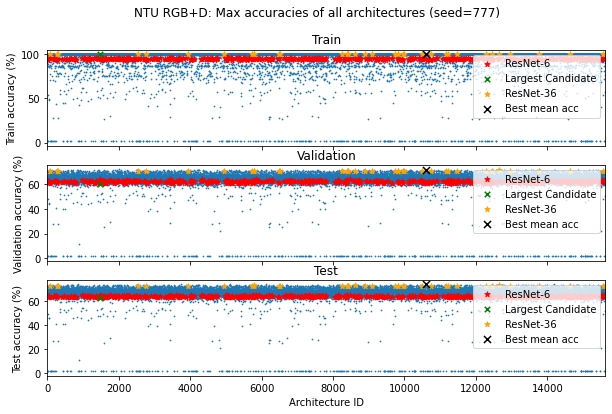

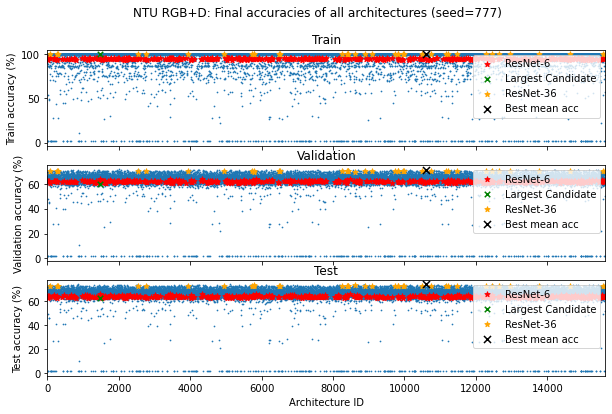

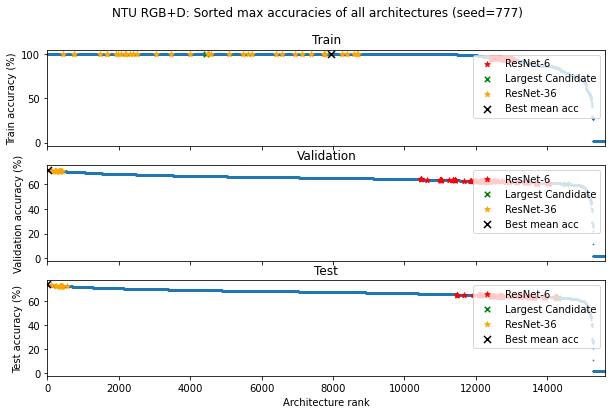

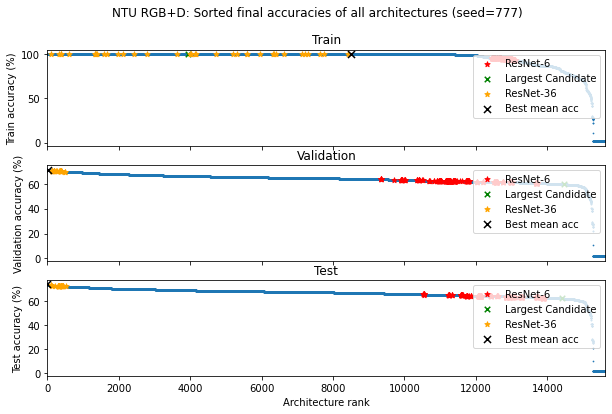

In [36]:
# get max accs and final of all Architectures
largest_id = 1462
# resnet_id = 11472
resnet_ids = [11472, 2528, 9950, 13755, 6515, 3927, 12295, 69, 9817, 15567, 12645, 14638, 9722, 5731, 9099, 9819, 12451,
              4946, 258, 6499, 8401, 8426, 2776, 12956, 8253, 5776, 9997, 295, 15615, 8606, 8413, 5780, 8884, 10750,
              11217, 10484, 11174]
skip_arch_ids = [3, 9, 25, 55, 72, 186, 196, 201, 243, 275, 278, 419, 464, 561, 594, 657, 659, 758, 777, 789, 970, 1020,
                 1051, 1061, 1110, 1140, 1164, 1194, 1263, 1310, 1351, 1384, 1409, 1481, 1497, 1520, 1549, 1565, 1574,
                 1601, 1610, 1637, 1690, 1755, 1785, 1860, 1863, 1872, 1921, 1962, 1977, 1995, 2090, 2132, 2134, 2152,
                 2191, 2196, 2211, 2222, 2241, 2265, 2279, 2286, 2304, 2385, 2417, 2481, 2485, 2493, 2518, 2560, 2595,
                 2707, 2747, 2773, 2803, 2894, 2985, 3022, 3076, 3105, 3157, 3294, 3347, 3374, 3393, 3438, 3442, 3449,
                 3495, 3501, 3521, 3610, 3665, 3679, 3686, 3691, 3728, 3746, 3793, 3885, 4010, 4028, 4031, 4054, 4100,
                 4314, 4326, 4384, 4481, 4506, 4512, 4554, 4556, 4559, 4587, 4603, 4607, 4618, 4686, 4739, 4752, 4754,
                 4988, 4998, 5007, 5019, 5022, 5030, 5033, 5034, 5064, 5084, 5148, 5163, 5174, 5275, 5326, 5339, 5373,
                 5398, 5400, 5419, 5489, 5502, 5507, 5534, 5552, 5598, 5640, 5680, 5724, 5763, 5764, 5779, 5806, 5842,
                 5913, 5915, 5939, 6014, 6121, 6136, 6216, 6257, 6259, 6279, 6280, 6296, 6453, 6490, 6634, 6672, 6682,
                 6730, 6782, 6783, 6796, 6822, 6863, 6901, 6918, 7017, 7110, 7118, 7187, 7213, 7239, 7241, 7295, 7316,
                 7331, 7341, 7392, 7401, 7404, 7422, 7476, 7503, 7542, 7583, 7594, 7622, 7663, 7682, 7690, 7723, 7781,
                 7796, 8048, 8062, 8126, 8140, 8146, 8177, 8178, 8316, 8324, 8332, 8370, 8392, 8393, 8462, 8574, 8579,
                 8638, 8664, 8671, 8687, 8737, 8741, 8764, 8912, 8954, 9040, 9152, 9200, 9210, 9230, 9241, 9282, 9317,
                 9383, 9394, 9425, 9510, 9545, 9650, 9820, 9832, 9840, 9922, 9947, 10132, 10134, 10146, 10222, 10240,
                 10293, 10403, 10431, 10433, 10465, 10491, 10543, 10582, 10643, 10673, 10714, 10787, 10797, 10888,
                 10900, 11067, 11172, 11184, 11214, 11231, 11241, 11261, 11292, 11308, 11323, 11373, 11382, 11397,
                 11430, 11464, 11479, 11482, 11495, 11531, 11572, 11629, 11656, 11720, 11772, 11826, 11862, 11935,
                 11936, 11946, 11994, 12033, 12103, 12190, 12268, 12286, 12302, 12328, 12335, 12430, 12437, 12439,
                 12445, 12453, 12462, 12475, 12615, 12670, 12681, 12841, 12876, 12896, 12918, 12927, 12952, 13047,
                 13057, 13098, 13153, 13195, 13258, 13321, 13380, 13386, 13401, 13491, 13521, 13618, 13646, 13656,
                 13659, 13684, 13734, 13763, 13856, 13931, 14056, 14108, 14109, 14117, 14133, 14146, 14241, 14366,
                 14389, 14392, 14407, 14467, 14483, 14527, 14530, 14544, 14550, 14584, 14589, 14593, 14608, 14612,
                 14674, 14690, 14694, 14733, 14766, 14848, 14852, 14863, 14937, 14945, 14974, 14982, 14989, 15014,
                 15075, 15160, 15193, 15206, 15242, 15288, 15370, 15438, 15472, 15532, 15569, 15589, 15595, 15596,
                 15620]

if export_analysis:
    Path(f"./analysis/{data_set_prefix}").mkdir(parents=True, exist_ok=True)

resnet_6_color = 'red'
resnet_36_color = 'orange'
largest_color = 'green'
best_arch_color = 'black'

for sorted in [False, True]:
    for prefix_type in ['max', 'final']:
        acc_type = prefix_type + '_acc'
        if len(seeds) > 1:
            seeds_and_mean = [*seeds, 'mean']
        else:
            seeds_and_mean = seeds
        for seed in seeds_and_mean:
            fig, axs = plt.subplots(3, figsize=(10, 6))
            if seed == 'mean':
                figure_title = f'{data_set_name_thesis}: {"Sorted mean" if sorted else "Mean"} {prefix_type} accuracies of all architectures'
            else:
                figure_title = f'{data_set_name_thesis}: {"Sorted " + prefix_type if sorted else prefix_type.capitalize()} accuracies of all architectures (seed={seed})'
            fig.suptitle(figure_title)
            for data_type_index in range(len(data_types)):
                a = axs[data_type_index]
                a.margins(x=0)
                data_type = data_types[data_type_index]
                text = data_type.capitalize()
                a.set_title(text)
                if sorted:
                    a.set(xlabel='Architecture rank', ylabel=text + ' accuracy (%)')
                    arr = np.array(acc_dict[acc_type][seed][data_type])[acc_dict_sorted_ids[acc_type][seed][data_type]]
                    sort_ids_arr = acc_dict_sorted_ids[acc_type][seed][data_type]
                else:
                    a.set(xlabel='Architecture ID', ylabel=text + ' accuracy (%)')
                    arr = acc_dict[acc_type][seed][data_type]
                    sort_ids_arr = acc_dict_sorted_ids[acc_type][seed][data_type]
                a.label_outer()

                a.scatter(range(len(arr)), arr, s=0.5, marker="o")
                # highlight largest
                if sorted:
                    current_resnet_ids = []
                    current_skip_arch_ids = []
                    for resnet_id in resnet_ids:
                        current_resnet_id = np.where(sort_ids_arr == resnet_id)[0][0]
                        current_resnet_ids.append(current_resnet_id)
                    for skip_arch in skip_arch_ids:
                        current_skip_id = np.where(sort_ids_arr == skip_arch)[0][0]
                        current_skip_arch_ids.append(current_skip_id)
                    current_largest_id = np.where(sort_ids_arr == largest_id)[0][0]
                    current_best_mean_arch = np.where(sort_ids_arr == best_mean_id)[0][0]
                else:
                    current_largest_id = largest_id
                    current_resnet_ids = resnet_ids
                    current_skip_arch_ids = skip_arch_ids
                    current_best_mean_arch = best_mean_id
                # if len(arr) > largest_id:
                a.scatter(current_skip_arch_ids, np.array(arr)[current_skip_arch_ids], color=resnet_6_color, marker='*',
                          label="ResNet-6", s=30)
                a.scatter([current_largest_id], [arr[current_largest_id]], color=largest_color, marker='x',
                          label="Largest Candidate", s=30)
                # a.legend(loc="lower right")

                # highlight ResNet if available
                # if len(arr) > resnet_id:
                # a.scatter([current_resnet_id], [arr[current_resnet_id]], color="orange", marker='*', label="ResNet", s=30)
                a.scatter(current_resnet_ids, np.array(arr)[current_resnet_ids], color=resnet_36_color, marker='*',
                          label="ResNet-36", s=30)
                # highlight best mean architecture
                a.scatter([current_best_mean_arch], [arr[current_best_mean_arch]], color=best_arch_color, marker='x',
                          label="Best mean acc", s=50)

                a.legend(loc="upper right")
            output_name = get_output_name_by_title(figure_title)
            if export_analysis:
                plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
            else:
                plt.show()

NTU RGB+D: Best Epoch for all architectures (final train accuracy, seed=777): 200, accuracy: 94.74709452227869
NTU RGB+D: Best Epoch for all architectures (final validation accuracy, seed=777): 199, accuracy: 62.85075768787409
NTU RGB+D: Best Epoch for all architectures (final test accuracy, seed=777): 198, accuracy: 65.1861353999098


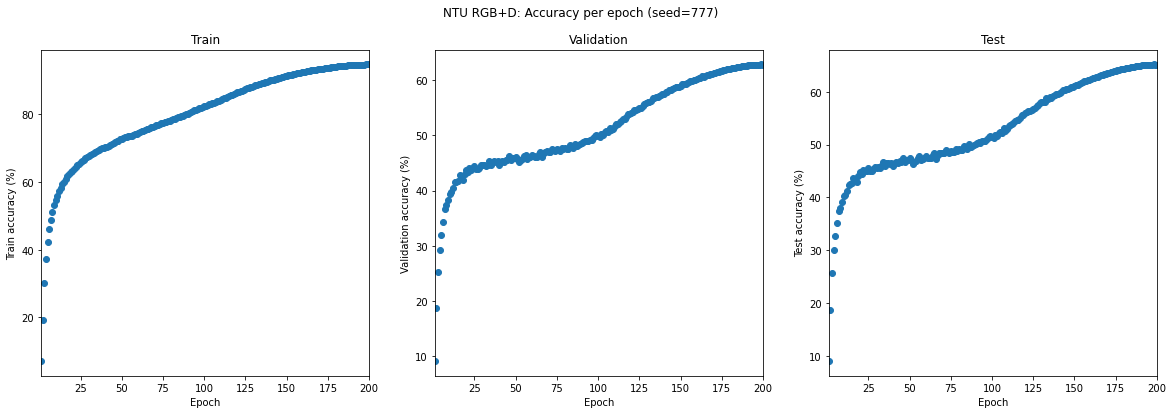

In [37]:
# per epochs
if len(seeds) > 1:
    seeds_and_mean = [*seeds, 'mean']
else:
    seeds_and_mean = seeds
for seed in seeds_and_mean:
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    if seed == 'mean':
        figure_title = f'{data_set_name_thesis}: Mean accuracy per epoch'
    else:
        figure_title = f'{data_set_name_thesis}: Accuracy per epoch (seed={seed})'
    fig.suptitle(figure_title)
    for data_type_index in range(len(data_types)):
        a = axs[data_type_index]
        a.margins(x=0)
        data_type = data_types[data_type_index]
        text = data_type.capitalize()
        a.set_title(text)
        a.set(xlabel='Epoch', ylabel=text + ' accuracy (%)')
        arr = epoch_accs[seed][data_type]
        # a.label_outer()
        a.scatter(range(1, len(arr) + 1), arr, marker="o")
        best_epoch = np.argmax(arr) + 1
        print(f"{data_set_name_thesis}: Best Epoch for all architectures ({prefix_type} {data_type} accuracy, seed={seed}): {best_epoch}, accuracy: {arr[best_epoch-1]}")
    output_name = get_output_name_by_title(figure_title, suffix="_full")
    if export_analysis:
        plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
    else:
        plt.show()


NTU RGB+D: Best Epoch for all architectures (final train accuracy, seed=777): 200, value: 1941
NTU RGB+D: Best Epoch for all architectures (final validation accuracy, seed=777): 199, value: 455
NTU RGB+D: Best Epoch for all architectures (final test accuracy, seed=777): 198, value: 677
NTU RGB+D: Best Epoch for all architectures (final train accuracy, seed=all): 200, value: 1941
NTU RGB+D: Best Epoch for all architectures (final validation accuracy, seed=all): 199, value: 455
NTU RGB+D: Best Epoch for all architectures (final test accuracy, seed=all): 198, value: 677


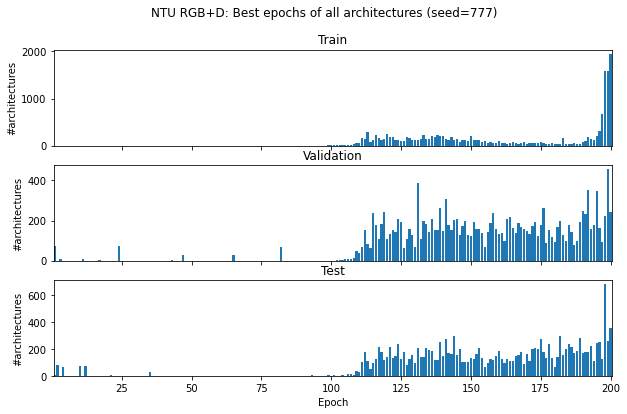

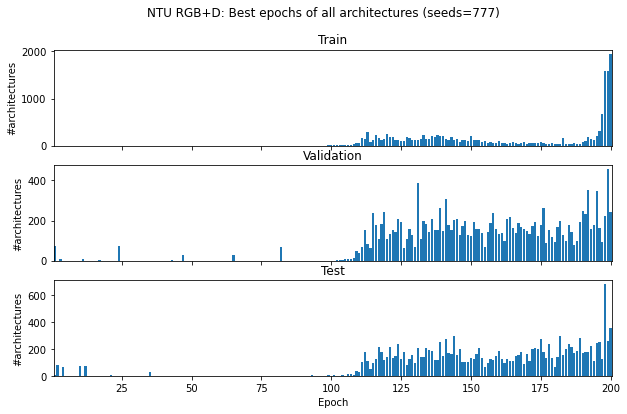

In [38]:
# print(epoch_best_indices)
# plt.cla()

if export_analysis:
    Path(f"./epoch_analysis/{data_set_prefix}").mkdir(parents=True, exist_ok=True)

for seed in [*seeds_and_mean, 'all']:
    fig, axs = plt.subplots(3, figsize=(10, 6))
    for data_type_index in range(len(data_types)):
        a = axs[data_type_index]
        a.margins(x=0)
        data_type = data_types[data_type_index]
        text = data_type.capitalize()
        a.set_title(text)
        a.set(xlabel='Epoch', ylabel="#architectures")
        if seed != 'all':
            data = epoch_best_indices[seed][data_type]
        else:
            data = []
            for seed_i in seeds:
                data.extend(epoch_best_indices[seed_i][data_type])
        # data = epoch_best_indices[seed][data_type]
        bins = range(201)
        counts, bins = np.histogram(data, bins=bins)
        best_epoch = np.argmax(counts) + 1
        print(f"{data_set_name_thesis}: Best Epoch for all architectures ({prefix_type} {data_type} accuracy, seed={seed}): {best_epoch}, value: {counts[best_epoch-1]}")
        # plt.cla()
        # print(data_type)
        # print(list(zip(range(1,200), counts)))
        # print(data_type_index)
        a.label_outer()
        a.bar(range(1,201),counts)

# todo add mean
    if seed == 'all':
        figure_title = f'{data_set_name_thesis}: Best epochs of all architectures (seeds={",".join(seeds)})'
    elif seed == 'mean':
        figure_title = f'{data_set_name_thesis}: Best epochs of all architectures (mean accuracy of all seeds)'
    else:
        figure_title = f'{data_set_name_thesis}: Best epochs of all architectures (seed={seed})'
    fig.suptitle(figure_title)
    # plt.show()
    # plt.savefig(f"{data_set_prefix}_{seed}_best_epochs.pdf", facecolor='w')
    if export_analysis:
        output_name = get_output_name_by_title(figure_title)
        plt.savefig(f"./epoch_analysis/{data_set_prefix}/"+output_name, facecolor='w')
    else:
        plt.show()

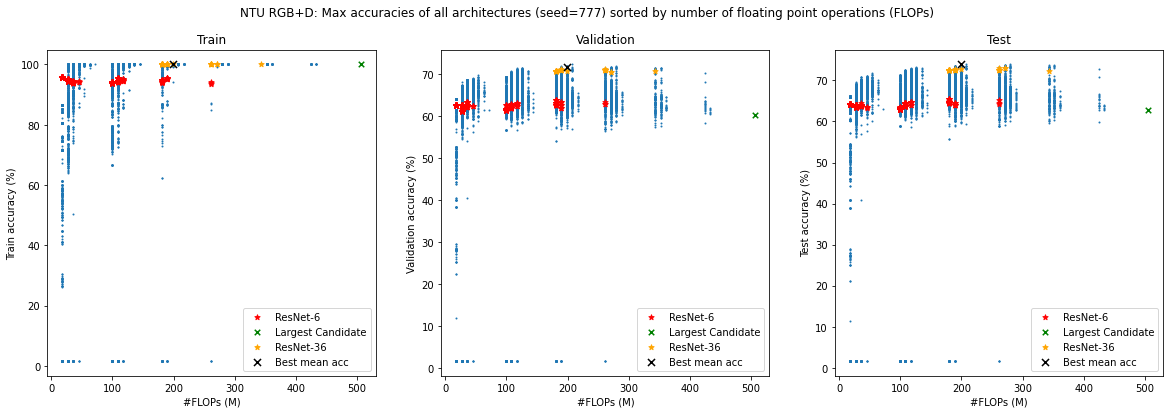

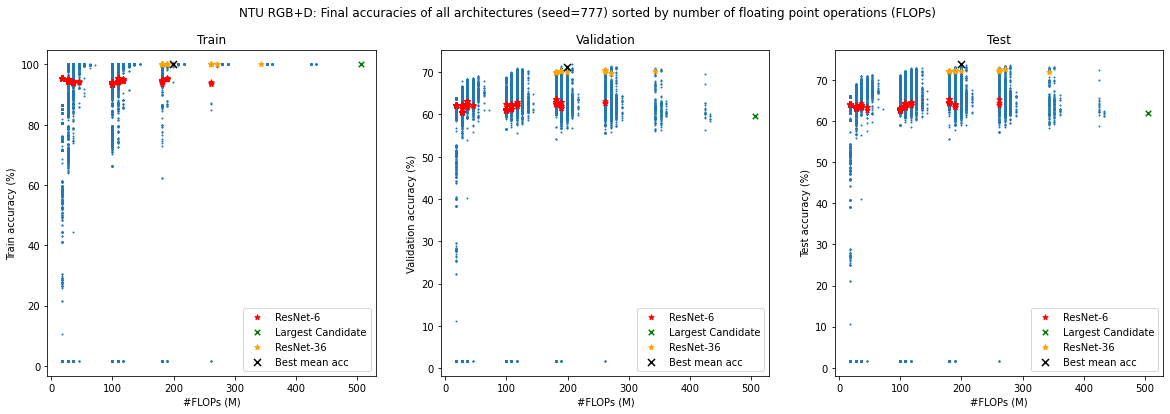

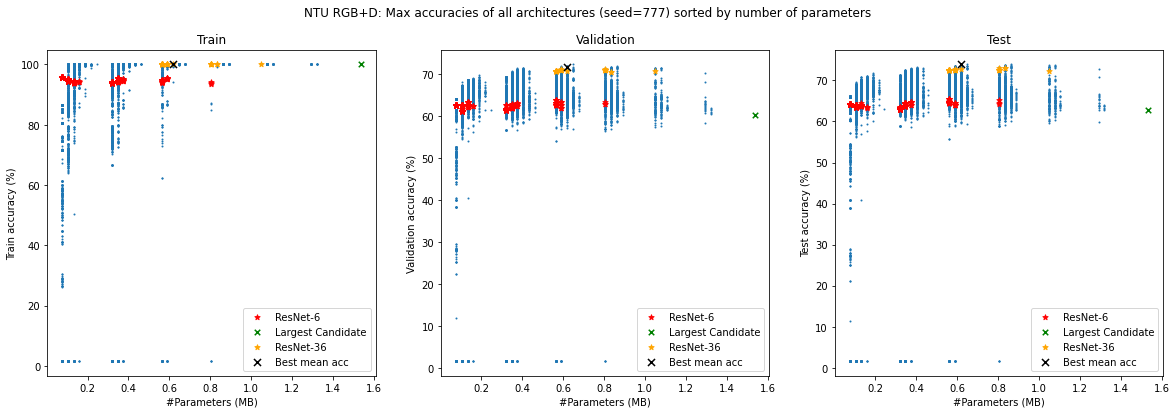

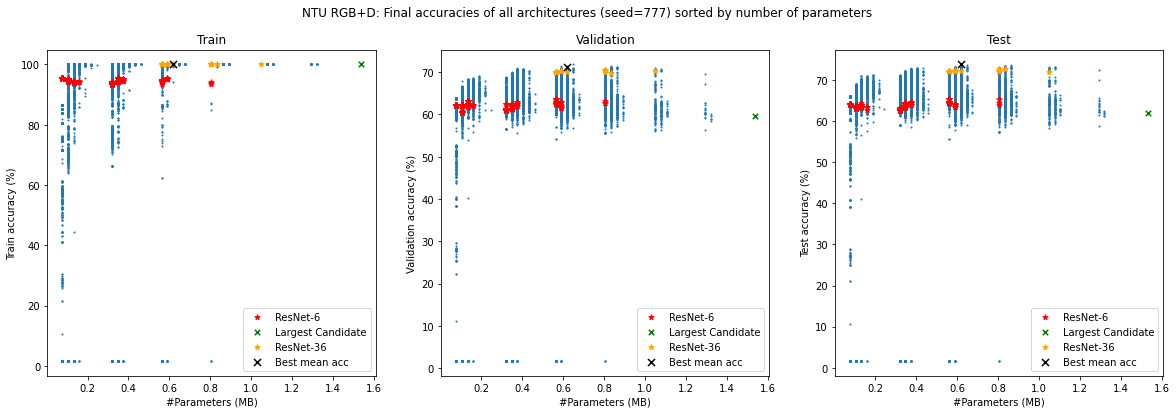

In [39]:
# number parameters and flops
flops_arr = []
params_arr = []
for index in range(len(all_data)):
    data_dict = all_data[index]
    flop = data_dict[dataset_name]['200']['additional_information']['flop']
    params = data_dict[dataset_name]['200']['additional_information']['params']
    flops_arr.append(flop)
    params_arr.append(params)
for xAxisType in ['flop', 'param']:
    for prefix_type in ['max', 'final']:
        acc_type = prefix_type + '_acc'
        if len(seeds) > 1:
            seeds_and_mean = [*seeds, 'mean']
        else:
            seeds_and_mean = seeds
        for seed in seeds_and_mean:
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
            if seed == 'mean':
                figure_title = f'{data_set_name_thesis}: Mean {prefix_type} accuracies of all architectures'
            else:
                figure_title = f'{data_set_name_thesis}: {prefix_type.capitalize()} accuracies of all architectures (seed={seed})'
            figure_title += f' sorted by number of {"floating point operations (FLOPs)" if xAxisType == "flop" else "parameters"}'
            fig.suptitle(figure_title)
            for data_type_index in range(len(data_types)):
                a = axs[data_type_index]
                # a.margins(x=0)
                data_type = data_types[data_type_index]
                text = data_type.capitalize()
                a.set_title(text)
                # load x data
                if xAxisType == 'flop':
                    a.set(xlabel='#FLOPs (M)', ylabel=text + ' accuracy (%)')
                    x_arr = flops_arr
                else:
                    a.set(xlabel='#Parameters (MB)', ylabel=text + ' accuracy (%)')
                    x_arr = params_arr
                # load y data
                arr = acc_dict[acc_type][seed][data_type]
                # a.label_outer()
                a.scatter(x_arr, arr, s=1, marker="o")
                # highlight largest
                current_largest_id = largest_id
                # current_resnet_id = resnet_id
                current_resnet_ids = resnet_ids
                current_skip_arch_ids = skip_arch_ids
                current_best_mean_arch = best_mean_id
                # if len(arr) > largest_id:
                a.scatter(np.array(x_arr)[current_skip_arch_ids], np.array(arr)[current_skip_arch_ids],
                          color=resnet_6_color, marker='*', label="ResNet-6", s=30)
                a.scatter([x_arr[largest_id]], [arr[largest_id]], color=largest_color, marker='x',
                          label="Largest Candidate", s=30)
                # a.legend(loc="lower right")

                # highlight ResNet if available
                # if len(arr) > resnet_id:
                a.scatter(np.array(x_arr)[current_resnet_ids], np.array(arr)[current_resnet_ids], color=resnet_36_color,
                          marker='*', label="ResNet-36", s=30)
                # highlight best mean architecture
                a.scatter(x_arr[current_best_mean_arch], [arr[current_best_mean_arch]], color=best_arch_color,
                          marker='x', label="Best mean acc", s=50)
                a.legend(loc="lower right")
            output_name = get_output_name_by_title(figure_title)
            if export_analysis:
                plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
            else:
                plt.show()

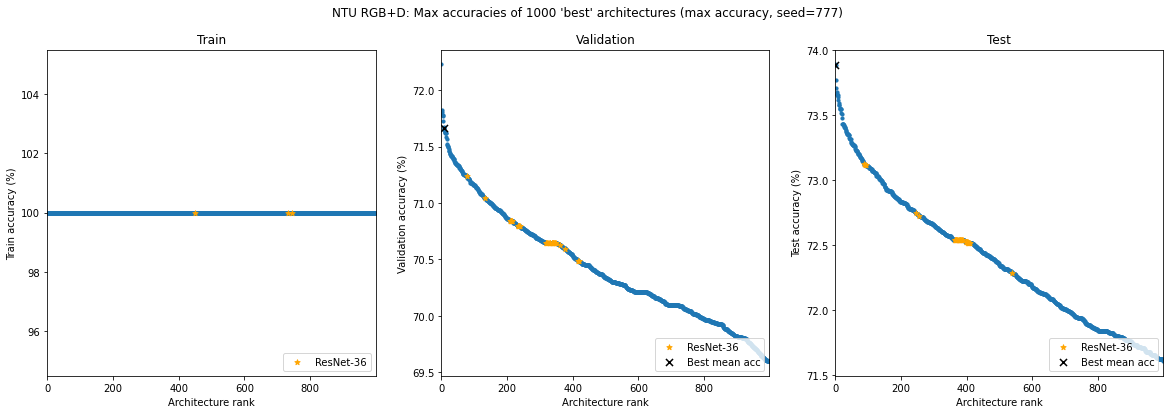

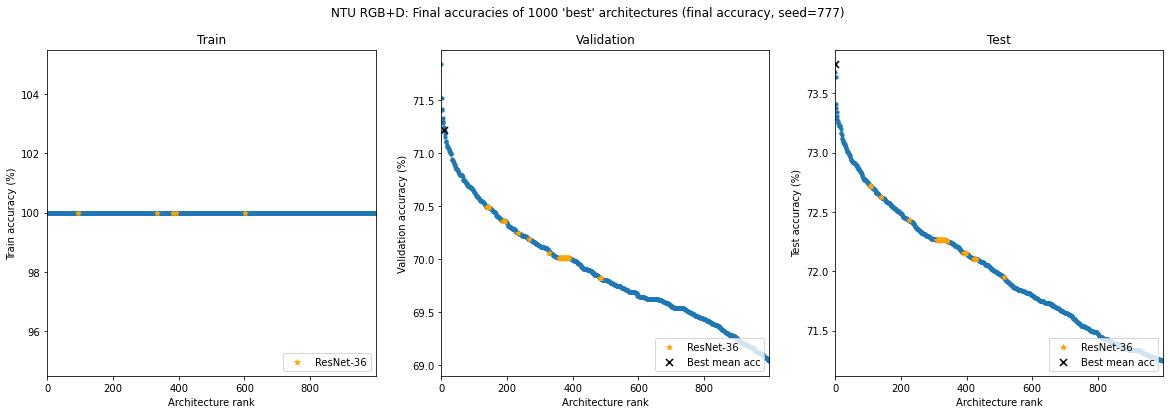

In [40]:
# top N Architectures
top_N = 1000
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    if len(seeds) > 1:
        seeds_and_mean = [*seeds, 'mean']
    else:
        seeds_and_mean = seeds
    for seed in seeds_and_mean:
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))
        if seed == 'mean':
            figure_title = f"{data_set_name_thesis}: Mean {prefix_type} accuracies of {top_N} 'best' architectures ({prefix_type} accuracy)"
        else:
            figure_title = f"{data_set_name_thesis}: {prefix_type.capitalize()} accuracies of {top_N} 'best' architectures ({prefix_type} accuracy, seed={seed})"
        fig.suptitle(figure_title)
        for data_type_index in range(len(data_types)):
            a = axs[data_type_index]
            a.margins(x=0)
            data_type = data_types[data_type_index]
            text = data_type.capitalize()
            a.set_title(text)
            a.set(xlabel='Architecture rank', ylabel=text + ' accuracy (%)')
            # take the sorted path
            sort_ids_arr = acc_dict_sorted_ids[acc_type][seed][data_type]
            arr = np.array(acc_dict[acc_type][seed][data_type])[sort_ids_arr][:top_N]
            # a.label_outer()

            a.scatter(range(len(arr)), arr, s=10, marker="o")
            # calculate highlight ranks
            current_resnet_ids = []
            current_skip_arch_ids = []
            for resnet_id in resnet_ids:
                current_resnet_id = np.where(sort_ids_arr == resnet_id)[0][0]
                if current_resnet_id < top_N:
                    # print(current_resnet_id)
                    current_resnet_ids.append(current_resnet_id)
            for skip_arch in skip_arch_ids:
                current_skip_id = np.where(sort_ids_arr == skip_arch)[0][0]
                if current_skip_id < top_N:
                    current_skip_arch_ids.append(current_skip_id)
            current_largest_id = np.where(sort_ids_arr == largest_id)[0][0]
            current_best_mean_arch = np.where(sort_ids_arr == best_mean_id)[0][0]
            # current_resnet_id = np.where(sort_ids_arr == resnet_id)[0]
            # current_largest_id = np.where(sort_ids_arr == largest_id)[0]
            # highlight skip
            if len(current_skip_arch_ids) > 0:
                a.scatter(current_skip_arch_ids, np.array(arr)[current_skip_arch_ids], color=resnet_6_color, marker='*',
                          label="ResNet-6", s=30)
                a.legend(loc="lower right")
            # highlight largest
            if len(arr) > current_largest_id:
                a.scatter([current_largest_id], [arr[current_largest_id]], color=largest_color, marker='x',
                          label="Largest Candidate", s=30)
                a.legend(loc="lower right")

            # highlight ResNet if available
            # print(current_resnet_ids)
            if len(current_resnet_ids) > 0:
                a.scatter(current_resnet_ids, np.array(arr)[current_resnet_ids], color=resnet_36_color, marker='*',
                          label="ResNet-36", s=30)
                a.legend(loc="lower right")
            # highlight best mean architecture
            if len(arr) > current_best_mean_arch:
                a.scatter([current_best_mean_arch], [arr[current_best_mean_arch]], color=best_arch_color, marker='x',
                          label="Best mean acc", s=50)
                a.legend(loc="lower right")
        output_name = get_output_name_by_title(figure_title)
        if export_analysis:
            plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
        else:
            plt.show()

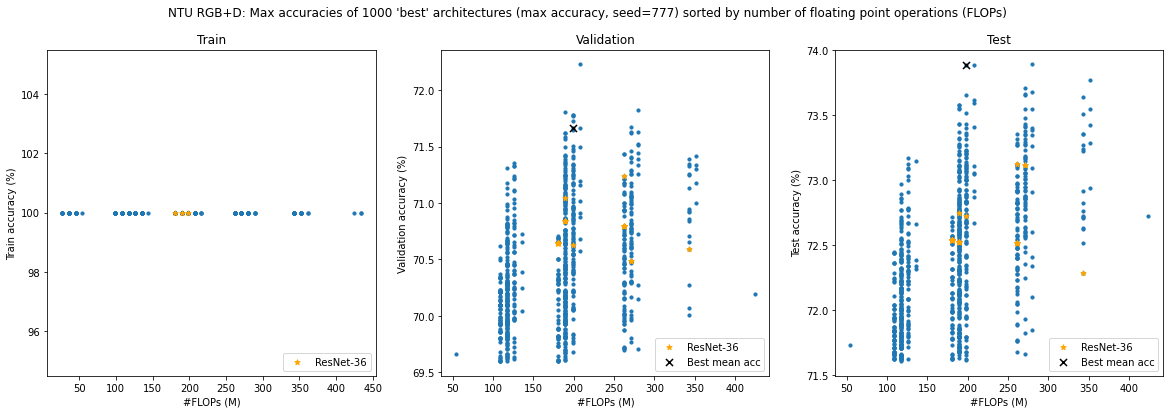

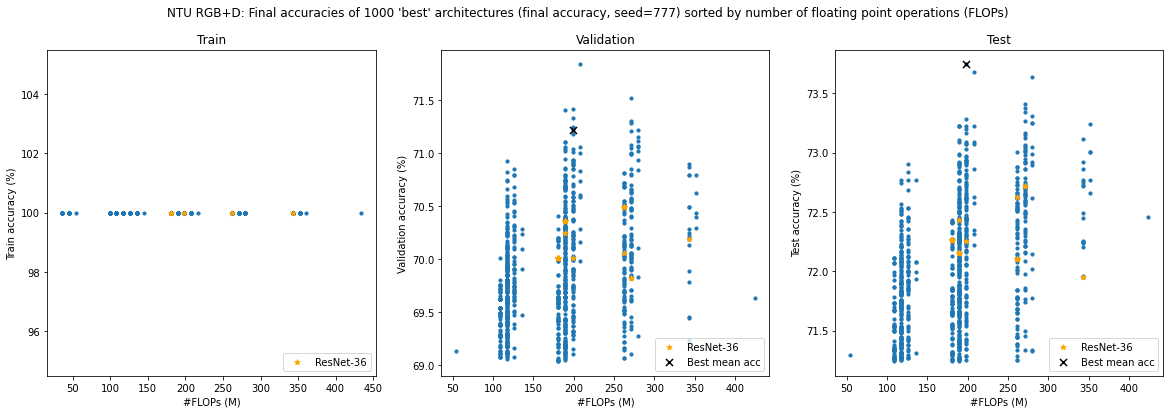

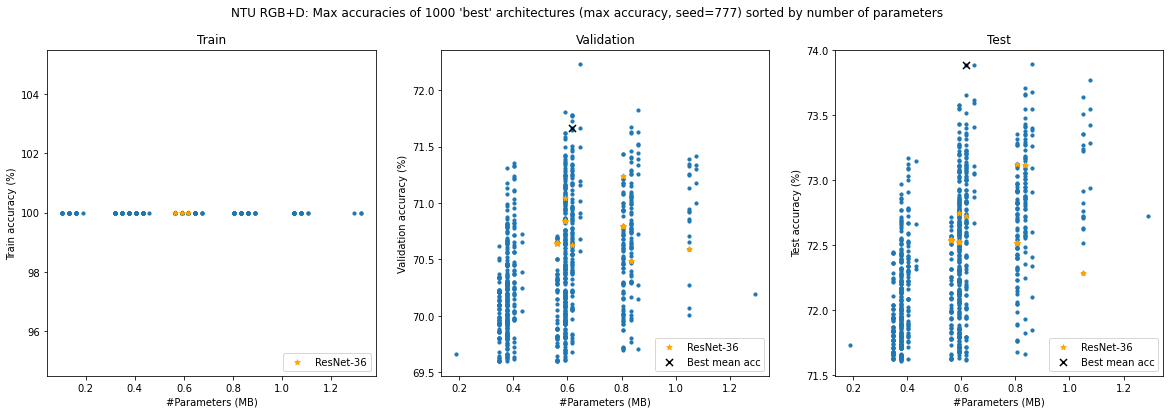

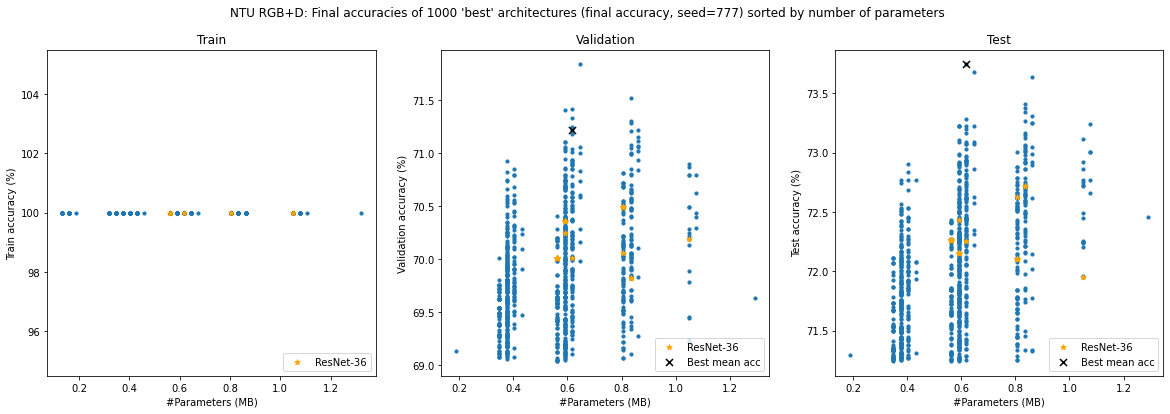

In [41]:
# top_N with #parameters and flops
# get number parameters and flops for top_n
# flops_arr = []
# params_arr = []
# for index in range(len(all_data)):
#     data_dict = all_data[index]
#     flop = data_dict['utdmhad']['200']['additional_information']['flop']
#     params = data_dict['utdmhad']['200']['additional_information']['params']
#     flops_arr.append(flop)
#     params_arr.append(params)
for xAxisType in ['flop', 'param']:
    for prefix_type in ['max', 'final']:
        acc_type = prefix_type + '_acc'
        if len(seeds) > 1:
            seeds_and_mean = [*seeds, 'mean']
        else:
            seeds_and_mean = seeds
        for seed in seeds_and_mean:
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
            if seed == 'mean':
                figure_title = f"{data_set_name_thesis}: Mean {prefix_type} accuracies of {top_N} 'best' architectures ({prefix_type} accuracy)"
            else:
                figure_title = f"{data_set_name_thesis}: {prefix_type.capitalize()} accuracies of {top_N} 'best' architectures ({prefix_type} accuracy, seed={seed})"
            figure_title += f' sorted by number of {"floating point operations (FLOPs)" if xAxisType == "flop" else "parameters"}'
            fig.suptitle(figure_title)
            for data_type_index in range(len(data_types)):
                a = axs[data_type_index]
                # a.margins(x=0)
                data_type = data_types[data_type_index]
                text = data_type.capitalize()
                a.set_title(text)
                # load x data
                if xAxisType == 'flop':
                    a.set(xlabel='#FLOPs (M)', ylabel=text + ' accuracy (%)')
                    x_arr = flops_arr
                else:
                    a.set(xlabel='#Parameters (MB)', ylabel=text + ' accuracy (%)')
                    x_arr = params_arr
                # load y data
                sort_ids_arr = acc_dict_sorted_ids[acc_type][seed][data_type]
                arr = np.array(acc_dict[acc_type][seed][data_type])[sort_ids_arr][:top_N]
                x_array_sorted = np.array(x_arr)[sort_ids_arr][:top_N]
                # a.label_outer()
                a.scatter(x_array_sorted, arr, s=10, marker="o")
                # highlight largest and resnet
                # calculate highlight ranks
                current_resnet_ids = []
                current_skip_arch_ids = []
                for resnet_id in resnet_ids:
                    current_resnet_id = np.where(sort_ids_arr == resnet_id)[0][0]
                    if current_resnet_id < top_N:
                        current_resnet_ids.append(current_resnet_id)
                for skip_arch in skip_arch_ids:
                    current_skip_id = np.where(sort_ids_arr == skip_arch)[0][0]
                    if current_skip_id < top_N:
                        current_skip_arch_ids.append(current_skip_id)
                current_largest_id = np.where(sort_ids_arr == largest_id)[0][0]
                current_best_mean_arch = np.where(sort_ids_arr == best_mean_id)[0][0]
                # highlight skip
                if len(current_skip_arch_ids) > 0:
                    a.scatter(np.array(x_array_sorted)[current_skip_arch_ids], np.array(arr)[current_skip_arch_ids],
                              color=resnet_6_color, marker='*', label="ResNet-6", s=30)
                    a.legend(loc="lower right")
                # highlight largest
                if len(arr) > current_largest_id:
                    a.scatter(x_array_sorted[current_largest_id], [arr[current_largest_id]], color=largest_color,
                              marker='x', label="Largest Candidate", s=30)
                    a.legend(loc="lower right")
                # highlight ResNet if available
                if len(current_resnet_ids) > 0:
                    a.scatter(np.array(x_array_sorted)[current_resnet_ids], np.array(arr)[current_resnet_ids],
                              color=resnet_36_color, marker='*', label="ResNet-36", s=30)
                    a.legend(loc="lower right")
                    # highlight best mean architecture
                if len(arr) > current_best_mean_arch:
                    a.scatter(x_array_sorted[current_best_mean_arch], [arr[current_best_mean_arch]],
                              color=best_arch_color, marker='x', label="Best mean acc", s=50)
                    a.legend(loc="lower right")
                # # highlight ResNet if available
                # if len(arr) > current_resnet_id:
                #     a.scatter(x_array_sorted[current_resnet_id], [arr[current_resnet_id]], color="orange", marker='*', label="ResNet", s=30)
                #     a.legend(loc="lower right")
            output_name = get_output_name_by_title(figure_title)
            if export_analysis:
                plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
            else:
                plt.show()

NTU RGB+D: Best Epoch for top 1000 (max train accuracy, seed=777): 196, accuracy: 99.99987663729581
NTU RGB+D: Best Epoch for top 1000 (max validation accuracy, seed=777): 175, accuracy: 69.97400637408809
NTU RGB+D: Best Epoch for top 1000 (max test accuracy, seed=777): 189, accuracy: 72.03481530345047
NTU RGB+D: Best Epoch for top 1000 (final train accuracy, seed=777): 200, accuracy: 100.0
NTU RGB+D: Best Epoch for top 1000 (final validation accuracy, seed=777): 175, accuracy: 69.95228251109195
NTU RGB+D: Best Epoch for top 1000 (final test accuracy, seed=777): 189, accuracy: 72.04569053850027


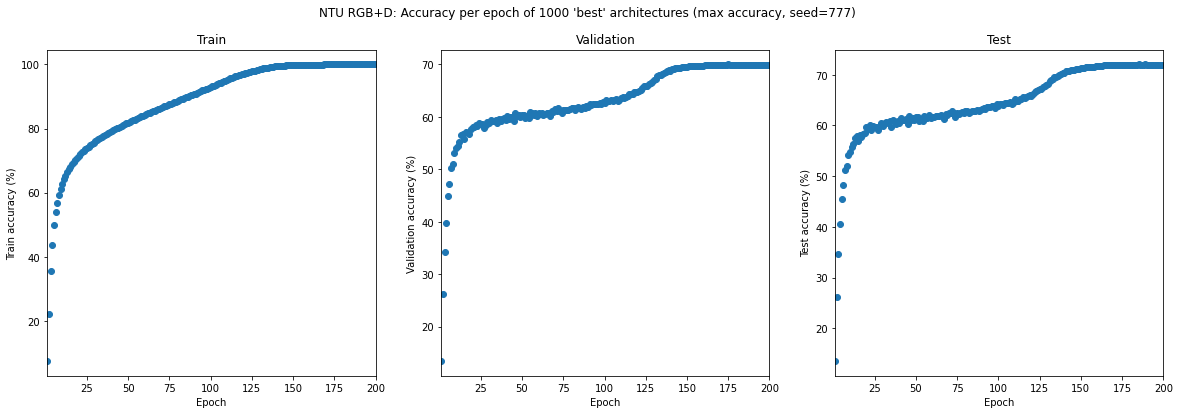

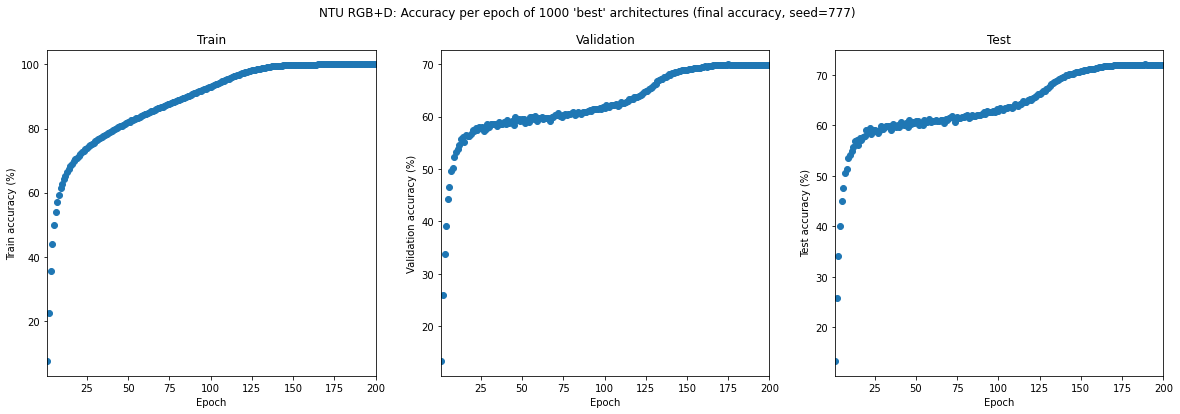

In [42]:
# top_N epochs
# calculate epochs
# preparation per epoch
top_N_epoch_accs = {}

for acc_type in ['max', 'final']:
    acc_type_string = acc_type + '_acc'
    top_N_epoch_accs[acc_type_string] = {}
    if len(seeds) > 1:
        seeds_and_mean = [*seeds, 'mean']
    else:
        seeds_and_mean = seeds
    for seed in seeds_and_mean:
        top_N_epoch_accs[acc_type_string][seed] = {'train': np.zeros(200), 'validation': np.zeros(200),
                                                   'test': np.zeros(200)}

# top_N_epoch_accs['max_acc'] = {'777': {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, '888' : {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, '999' : {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, 'mean': {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}}
# top_N_epoch_accs['final_acc'] = {'777': {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, '888' : {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, '999' : {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}, 'mean': {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}}

# calculation per epoch
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    if len(seeds) > 1:
        seeds_and_mean = [*seeds, 'mean']
    else:
        seeds_and_mean = seeds
    for seed in seeds_and_mean:
        for data_type_index in range(len(data_types)):
            data_type = data_types[data_type_index]
            sort_ids_arr = acc_dict_sorted_ids[acc_type][seed][data_type]
            for place in range(top_N):
                index = sort_ids_arr[place]
                data_dict = all_data[index]
                # safe information per epoch
                if seed == 'mean':
                    mean_acc1es = np.zeros(200)
                    for seed_temp in seeds:
                        acc1es = get_epoch_accs(data_dict, seed_temp, dataset=dataset_name)
                        mean_acc1es = np.add(mean_acc1es, acc1es[data_type_index])
                    mean_acc1es = mean_acc1es / len(seeds)
                    top_N_epoch_accs[acc_type][seed][data_type] = np.add(top_N_epoch_accs[acc_type][seed][data_type],
                                                                         mean_acc1es)
                else:
                    acc1es = get_epoch_accs(data_dict, seed, dataset=dataset_name)
                    top_N_epoch_accs[acc_type][seed][data_type] = np.add(top_N_epoch_accs[acc_type][seed][data_type],
                                                                         acc1es[data_type_index])
            top_N_epoch_accs[acc_type][seed][data_type] = top_N_epoch_accs[acc_type][seed][data_type] / top_N

# show data
# per epochs
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    if len(seeds) > 1:
        seeds_and_mean = [*seeds, 'mean']
    else:
        seeds_and_mean = seeds
    for seed in seeds_and_mean:
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))
        if seed == 'mean':
            figure_title = f"{data_set_name_thesis}: Mean accuracy per epoch of {top_N} 'best' architectures ({prefix_type} accuracy)"
        else:
            figure_title = f"{data_set_name_thesis}: Accuracy per epoch of {top_N} 'best' architectures ({prefix_type} accuracy, seed={seed})"
        fig.suptitle(figure_title)
        for data_type_index in range(len(data_types)):
            a = axs[data_type_index]
            a.margins(x=0)
            data_type = data_types[data_type_index]
            text = data_type.capitalize()
            a.set_title(text)
            a.set(xlabel='Epoch', ylabel=text + ' accuracy (%)')
            arr = top_N_epoch_accs[acc_type][seed][data_type]
            # a.label_outer()
            a.scatter(range(1, len(arr) + 1), arr, marker="o")
            best_epoch = np.argmax(arr) + 1
            print(f"{data_set_name_thesis}: Best Epoch for top {top_N} ({prefix_type} {data_type} accuracy, seed={seed}): {best_epoch}, accuracy: {arr[best_epoch-1]}")
        output_name = get_output_name_by_title(figure_title)
        if export_analysis:
            plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
        else:
            plt.show()

NTU RGB+D: Best Epoch for top 1000 (max train accuracy, seed=777): 113, value: 35
NTU RGB+D: Best Epoch for top 1000 (max validation accuracy, seed=777): 141, value: 90
NTU RGB+D: Best Epoch for top 1000 (max test accuracy, seed=777): 146, value: 58
NTU RGB+D: Best Epoch for top 1000 (final train accuracy, seed=777): 113, value: 39
NTU RGB+D: Best Epoch for top 1000 (final validation accuracy, seed=777): 141, value: 90
NTU RGB+D: Best Epoch for top 1000 (final test accuracy, seed=777): 146, value: 55


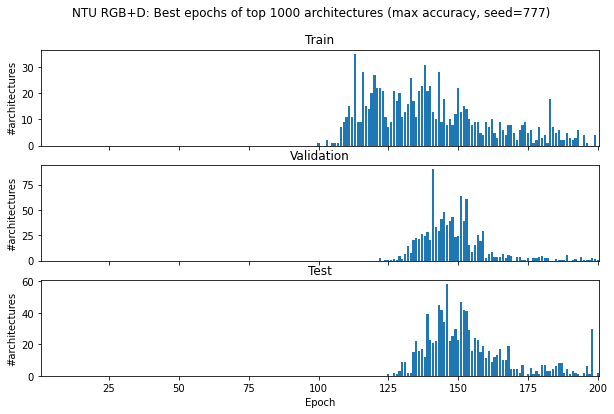

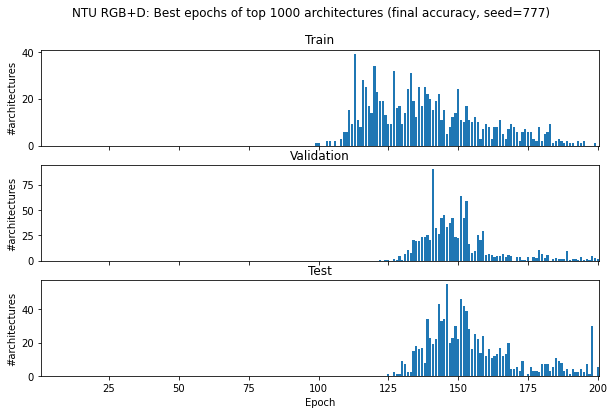

In [43]:
# if export_analysis:
#     Path(f"./epoch_analysis/{data_set_prefix}").mkdir(parents=True, exist_ok=True)


for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    if len(seeds) > 1:
        seeds_and_mean = [*seeds, 'mean', 'all']
    else:
        seeds_and_mean = seeds
    for seed in seeds_and_mean:
        fig, axs = plt.subplots(3, figsize=(10, 6))
        for data_type_index in range(len(data_types)):
            data_type = data_types[data_type_index]
            mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
            if seed != 'all':
                epoch_data = epoch_best_indices[seed][data_type]
                top_N_epoch_data = np.array(epoch_data)[mean_sorted_ids[:top_N]]
            else:
                top_N_epoch_data = []
                for seed_i in seeds:
                    epoch_data = epoch_best_indices[seed_i][data_type]
                    top_N_epoch_data.extend(np.array(epoch_data)[mean_sorted_ids[:top_N]])
            a = axs[data_type_index]
            a.margins(x=0)
            text = data_type.capitalize()
            a.set_title(text)
            a.set(xlabel='Epoch', ylabel="#architectures")
            data = top_N_epoch_data
            bins = range(201)
            counts, bins = np.histogram(data, bins=bins)
            # plt.cla()
            # print(data_type)
            # print(list(zip(range(1,200), counts)))
            a.label_outer()
            # print(np.array(counts).sum())
            a.bar(range(1,201),counts, width=0.8)
            best_epoch = np.argmax(counts) + 1
            print(f"{data_set_name_thesis}: Best Epoch for top {top_N} ({prefix_type} {data_type} accuracy, seed={seed}): {best_epoch}, value: {counts[best_epoch-1]}")
        if seed != 'all':
            figure_title=f'{data_set_name_thesis}: Best epochs of top {top_N} architectures ({prefix_type} accuracy, seed={seed})'
        else:
            figure_title=f'{data_set_name_thesis}: Best epochs of top {top_N} architectures ({prefix_type} accuracy, seeds={",".join(seeds)})'
        fig.suptitle(figure_title)
        if export_analysis:
            output_name = get_output_name_by_title(figure_title)
            plt.savefig(f"./epoch_analysis/{data_set_prefix}/"+output_name, facecolor='w')
        else:
            plt.show()

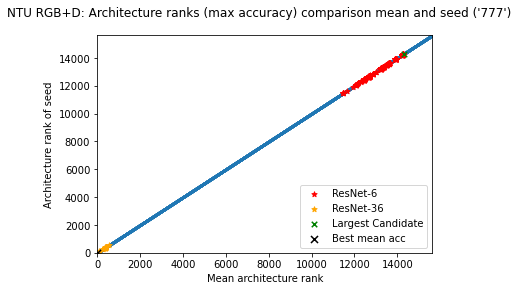

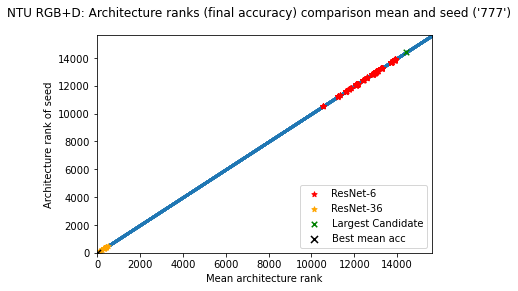

In [44]:
# show architecture ranks mean to seeds
data_type = 'test'
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]

    # fig, axs = plt.subplots(1,3)
    # fig.suptitle(f'Architecture ranks Mean and Seeds({seeds})')
    for seed_index in range(len(seeds)):
        seed = seeds[seed_index]
        # a = axs[seed_index]
        fig, a = plt.subplots()
        figure_title = f"{data_set_name_thesis}: Architecture ranks ({prefix_type} accuracy) comparison mean and seed ('{seed}')"
        fig.suptitle(figure_title)
        a.margins(x=0, y=0)
        sort_ids_arr = acc_dict_sorted_ids[acc_type][seed][data_type]
        y_axis = [np.where(sort_ids_arr == x)[0] for x in np.nditer(mean_sorted_ids, order='C')]
        a.set(xlabel='Mean architecture rank', ylabel=f'Architecture rank of seed')
        a.scatter(range(len(y_axis)), y_axis, s=1, marker="o")

        # calculate highlights
        current_resnet_ids_x = []
        current_resnet_ids_y = []
        current_skip_arch_ids_x = []
        current_skip_arch_ids_y = []
        for resnet_id in resnet_ids:
            current_resnet_id_x = np.where(mean_sorted_ids == resnet_id)[0][0]
            current_resnet_ids_x.append(current_resnet_id_x)
            current_resnet_id_y = np.where(sort_ids_arr == resnet_id)[0][0]
            current_resnet_ids_y.append(current_resnet_id_y)
        for skip_arch in skip_arch_ids:
            current_skip_id_x = np.where(mean_sorted_ids == skip_arch)[0][0]
            current_skip_arch_ids_x.append(current_skip_id_x)
            current_skip_id_y = np.where(sort_ids_arr == skip_arch)[0][0]
            current_skip_arch_ids_y.append(current_skip_id_y)
        current_largest_id = np.where(mean_sorted_ids == largest_id)[0][0]
        current_largest_id_y = np.where(sort_ids_arr == largest_id)[0][0]
        current_best_mean_arch = np.where(mean_sorted_ids == best_mean_id)[0][0]
        current_best_mean_arch_y = np.where(sort_ids_arr == best_mean_id)[0][0]
        # highlight skip
        a.scatter(current_skip_arch_ids_x, current_skip_arch_ids_y, color=resnet_6_color, marker='*', label="ResNet-6",
                  s=30)
        a.legend(loc="lower right")
        a.legend(loc="lower right")
        # highlight ResNet if available
        a.scatter(current_resnet_ids_x, current_resnet_ids_y, color=resnet_36_color, marker='*', label="ResNet-36",
                  s=30)
        a.legend(loc="lower right")
        # highlight largest
        a.scatter([current_largest_id], [current_largest_id_y], color=largest_color, marker='x',
                  label="Largest Candidate", s=30)
        # highlight best mean architecture
        a.scatter([current_best_mean_arch], [current_best_mean_arch_y], color=best_arch_color, marker='x',
                  label="Best mean acc", s=50)
        a.legend(loc="lower right")
    output_name = get_output_name_by_title(figure_title)
    if export_analysis:
        plt.savefig(f"./analysis/{data_set_prefix}/"+output_name, facecolor='w')
    else:
        plt.show()

In [45]:
# calculate correlations
from scipy.stats import pearsonr
from scipy.stats import spearmanr

data_type = 'test'
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    mean_data = acc_dict[acc_type]['mean'][data_type]
    for seed_1 in [*seeds, 'mean']:
        for seed_2 in [*seeds, 'mean']:
            if seed_1 != seed_2:
                seed_data_1 = acc_dict[acc_type][seed_1][data_type]
                seed_data_2 = acc_dict[acc_type][seed_2][data_type]
                print(f'Correlation {seed_1} and {seed_2} ({prefix_type.capitalize()} Accuracy):')
                corr, pval = pearsonr(seed_data_1, seed_data_2)
                corr_2, pval_2 = spearmanr(seed_data_1, seed_data_2)
                print('Pearsons correlation: %.3f' % corr)
                print('Spearman correlation: %.3f' % corr_2)

Correlation 777 and mean (Max Accuracy):
Pearsons correlation: 1.000
Spearman correlation: 1.000
Correlation mean and 777 (Max Accuracy):
Pearsons correlation: 1.000
Spearman correlation: 1.000
Correlation 777 and mean (Final Accuracy):
Pearsons correlation: 1.000
Spearman correlation: 1.000
Correlation mean and 777 (Final Accuracy):
Pearsons correlation: 1.000
Spearman correlation: 1.000


In [46]:
# architecture analysis functions
skip_connection_string = 'skip_connect'
no_path_string = 'none'
conv_substring = 'conv'
avg_substring = 'avg'
avg_fullstring = 'avg_pool_3x3'


# from NATS-Bench
def str2fullstructure(xstr):
    nodestrs = xstr.split("+")
    genotypes = []
    for i, node_str in enumerate(nodestrs):
        inputs = list(filter(lambda x: x != "", node_str.split("|")))
        inputs = (xi.split("~") for xi in inputs)
        input_infos = tuple((op, int(IDX)) for (op, IDX) in inputs)
        genotypes.append(input_infos)
    return genotypes


# self written parser
def get_edge_dict(architecture_string):
    genotypes = str2fullstructure(architecture_string)
    edge_dict = {}
    for target in range(1, 4):
        # the string shows all connections to the nodes (so per target)
        target_arr = genotypes[target - 1]
        for source in range(len(target_arr)):
            elem = target_arr[source][0]
            edge_dict[(source, target)] = elem
    return edge_dict


def get_color_array_for_edge_dict(edge_dict):
    edge_colors = []
    all_edges = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    for edge in all_edges:
        if edge in edge_dict:
            elem = edge_dict[edge]
            color = None
            if elem == 'none':
                # color = 'dodgerblue'
                color = '#00A2FF'
            if elem == 'skip_connect':
                # color = 'aquamarine'
                color = '#16E7CF'
            elif elem == 'nor_conv_1x1':
                # color = 'lime'
                color = '#61D836'
            elif elem == 'nor_conv_3x3':
                # color = 'yellow'
                color = '#FAE232'
            elif elem == 'avg_pool_3x3':
                # color = 'orangered'
                color = '#FF644E'
            if color:
                edge_colors.append(color)
    return edge_colors


def get_edge_array_for_edge_dict(edge_dict):
    return edge_dict.keys()


def get_edge_labels_and_colors(architecture_string):
    edge_dict = get_edge_dict(architecture_string)
    colors = get_color_array_for_edge_dict(edge_dict)
    return edge_dict, colors


# remove all paths with none edges
def reduce_to_relevant_graph(edge_dict):
    # (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)
    all_edges = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    edges_to_keep = all_edges.copy()

    def remove_if_included(index):
        if index in edges_to_keep:
            edges_to_keep.remove(index)

    # if not possible to come to X ignore all edges with X as start
    # if not possible to come to an end from 1 ignore all edges with X as end
    # remove all none edges first
    for edge in all_edges:
        edge_label = edge_dict[edge]
        if edge_label == no_path_string:
            edges_to_keep.remove(edge)
    if (0, 1) not in edges_to_keep or ((1, 2) not in edges_to_keep and (1, 3) not in edges_to_keep):
        # remove (0,1), (1,2), (1,3)
        remove_if_included((0, 1))
        remove_if_included((1, 2))
        remove_if_included((1, 3))
    if (2, 3) not in edges_to_keep or ((0, 2) not in edges_to_keep and (1, 2) not in edges_to_keep):
        # remove (0,2), (1,2), (2,3)
        remove_if_included((0, 2))
        remove_if_included((1, 2))
        remove_if_included((2, 3))
    if (0, 1) in edges_to_keep and not is_path_with_edge((0, 1), edge_dict):
        remove_if_included((0, 1))
    new_edge_dict = {}
    for edge_index in edges_to_keep:
        new_edge_dict[edge_index] = edge_dict[edge_index]
    return new_edge_dict


# has a path from 0 to 3 with only skip connections
def has_skip_connection_path(edge_dict):
    if (0, 3) in edge_dict and edge_dict[(0, 3)] == skip_connection_string:
        return True
    if (0, 1) in edge_dict and edge_dict[(0, 1)] == skip_connection_string:
        if (1, 2) in edge_dict and edge_dict[(1, 2)] == skip_connection_string and (2, 3) in edge_dict and edge_dict[
            (2, 3)] == skip_connection_string:
            return True
        elif (1, 3) in edge_dict and edge_dict[(1, 3)] == skip_connection_string:
            return True
    if (0, 2) in edge_dict and edge_dict[(0, 2)] == skip_connection_string and (2, 3) in edge_dict and edge_dict[
        (2, 3)] == skip_connection_string:
        return True
    return False


# calls has_skip_connection_path with the architecture that has the index
def has_architecture_skip_connection_path(index):
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    has_path = has_skip_connection_path(edge_dict)
    # if has_path:
    #     has_path_with_conv(edge_label)
    return has_path


def get_architecture_string_by_index(index):
    data_dict = all_data[index]
    architecture_string = data_dict[dataset_name]['200']['additional_information']['arch_str']
    return architecture_string


# checks if a graph has a path with an operation (example substring = 'conv' -> checks if there is a path with 1x1 or 3x3 conv)
def has_path_with_substring(edge_dict, substring=conv_substring):
    for index in edge_dict:
        elem = edge_dict[index]
        if substring in elem:
            # is path?
            is_path = is_path_with_edge(index, edge_dict)
            if is_path:
                return True
    return False


def has_path_with_conv(edge_dict):
    return has_path_with_substring(edge_dict, conv_substring)


def has_path_with_avg(edge_dict):
    return has_path_with_substring(edge_dict, avg_substring)


def is_path_with_edge(edge, edge_dict, check_if_is_none=True):
    def exists_edge(edge):
        return edge in edge_dict and edge_dict[edge] != no_path_string

    if check_if_is_none and edge_dict[edge] == no_path_string:
        return False
    start = edge[0]
    end = edge[1]
    is_start = False
    is_end = False
    # check is path to start
    if start == 0:
        is_start = True
    elif start == 1:
        is_start = exists_edge((0, 1))
    elif start == 2:
        is_start = exists_edge((0, 2)) or (exists_edge((0, 1)) and exists_edge((1, 2)))
    # check is path to end
    if is_start:
        if end == 3:
            is_end = True
        elif end == 2:
            is_end = exists_edge((2, 3))
        elif end == 1:
            is_end = exists_edge((1, 3)) or (exists_edge((2, 3)) and exists_edge((1, 2)))
        return is_start and is_end
    else:
        return False


def draw_graph_from_architecture_string(architecture_string, with_relevant=False, with_labels=False, title='',
                                        safeName=''):
    # predefines
    G = nx.DiGraph()
    nodes = np.arange(0, 4).tolist()
    G.add_nodes_from(nodes)
    G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
    labels = {0: '0', 1: '1', 2: '2', 3: '3'}
    # pos = nx.kamada_kawai_layout(G)
    pos = {0: (0, 0), 1: (2, 0), 2: (4, 0.5), 3: (6, -0.5)}

    edge_dict = get_edge_dict(architecture_string)
    edge_colors = get_color_array_for_edge_dict(edge_dict)
    plt.cla()

    if not with_relevant:
        if with_labels:
            nx.draw_networkx(G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                             edge_color=edge_colors, width=3)
            nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_dict, font_color='black', font_size=10)
        else:
            nx.draw_networkx(G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                             edge_color=edge_colors, width=6)
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        plt.sca(axs[0])
        nx.draw_networkx(G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                         edge_color=edge_colors, width=6)

        plt.sca(axs[1])
        new_G = nx.DiGraph()
        nodes = np.arange(0, 4).tolist()
        new_G.add_nodes_from(nodes)
        relevant_edges = reduce_to_relevant_graph(edge_dict)
        new_G.add_edges_from(relevant_edges.keys())
        new_edge_colors = get_color_array_for_edge_dict(relevant_edges)

        if with_labels:
            nx.draw_networkx(new_G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                             edge_color=new_edge_colors, width=3)
            nx.draw_networkx_edge_labels(new_G, pos=pos, edge_labels=relevant_edges, font_color='black', font_size=10)
        else:
            nx.draw_networkx(new_G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                             edge_color=new_edge_colors, width=6)
    if title:
        plt.suptitle(title)
    if not safeName:
        plt.show()
    else:
        plt.savefig(safeName, facecolor='w')

In [47]:
# test drawing a graph
# import networkx as nx

G = nx.DiGraph()

nodes = np.arange(0, 4).tolist()
G.add_nodes_from(nodes)
G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
labels = {0: '0', 1: '1', 2: '2', 3: '3'}
# pos = nx.kamada_kawai_layout(G)
pos = {0: (0, 0), 1: (2, 0), 2: (4, 0.5), 3: (6, -0.5)}

edge_label, edge_colors = get_edge_labels_and_colors(
    '|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|')
print(edge_label)
print(edge_colors)
# nx.draw_networkx(G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color = edge_colors)
# nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=edge_label,font_color='black')
# plt.title("Self written graph")
# plt.show()

{(0, 1): 'nor_conv_3x3', (0, 2): 'none', (1, 2): 'nor_conv_3x3', (0, 3): 'skip_connect', (1, 3): 'none', (2, 3): 'skip_connect'}
['#FAE232', '#00A2FF', '#16E7CF', '#FAE232', '#00A2FF', '#16E7CF']


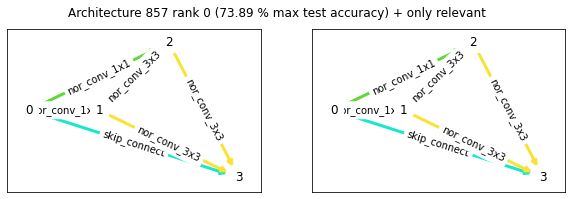

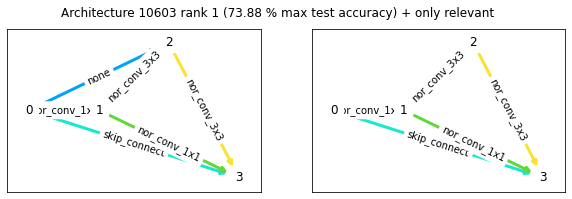

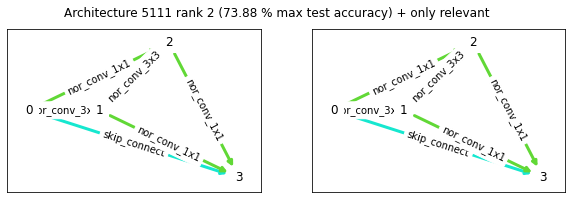

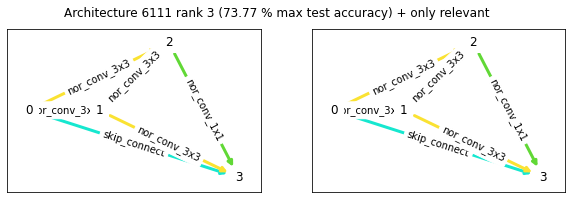

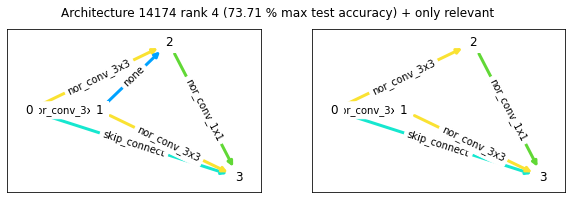

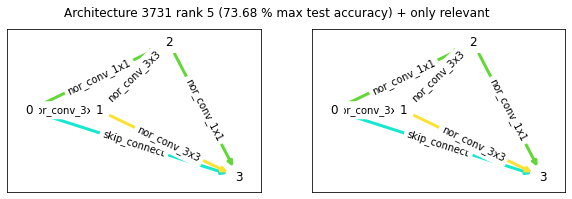

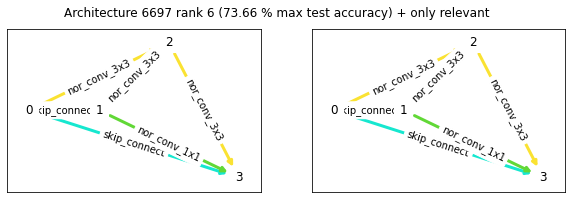

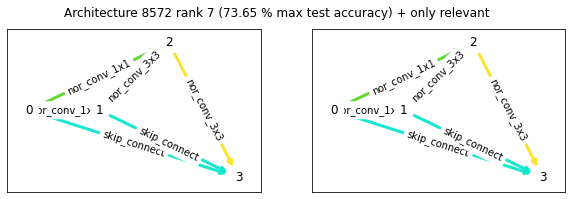

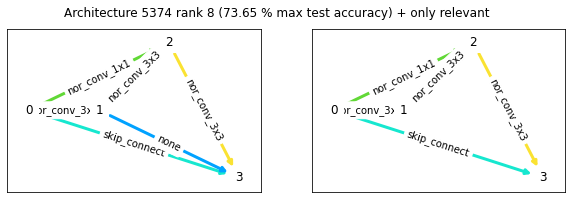

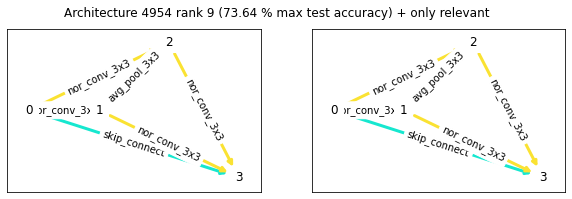

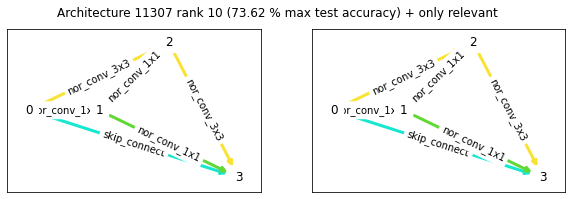

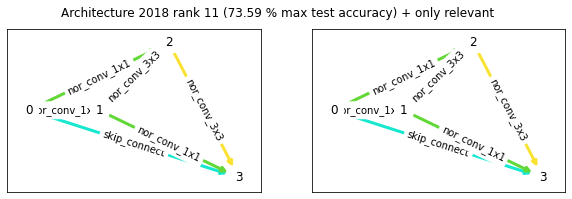

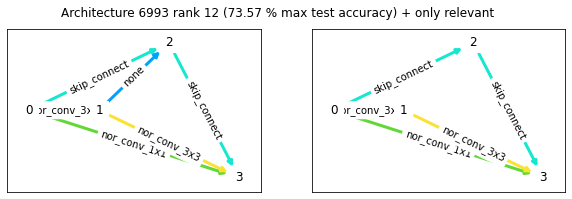

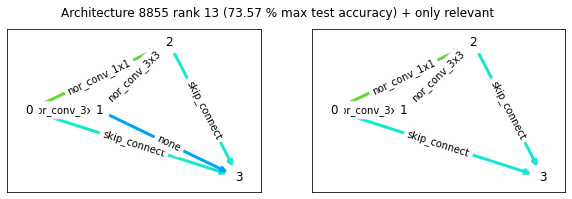

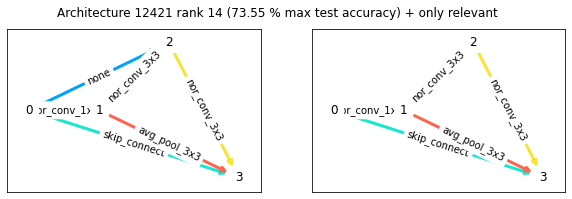

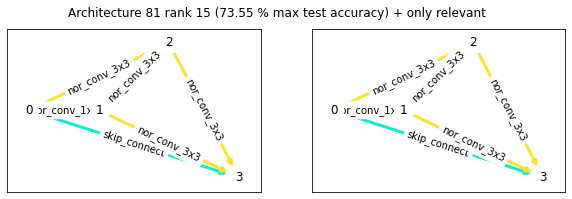

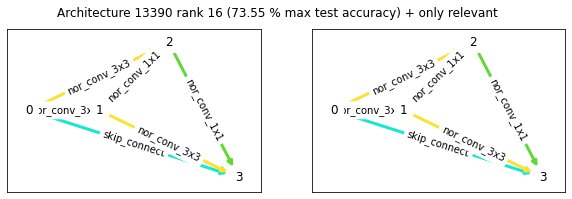

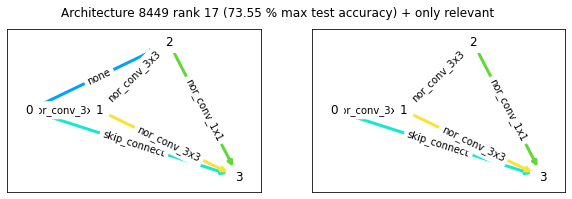

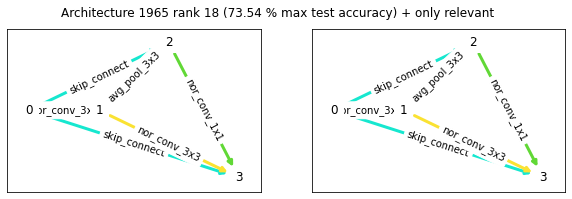

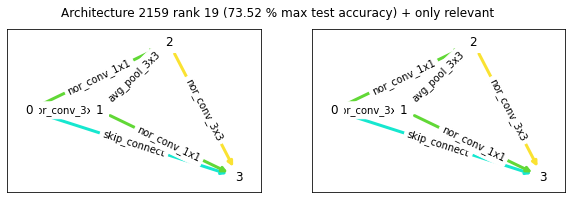

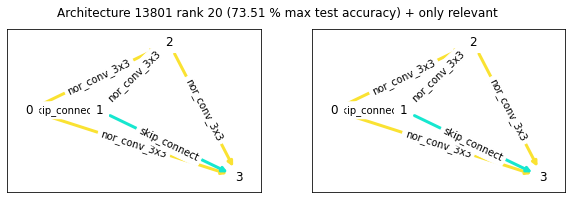

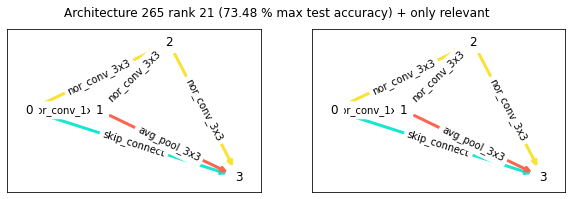

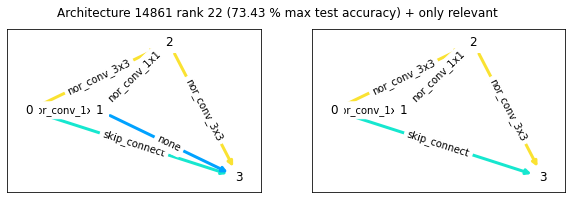

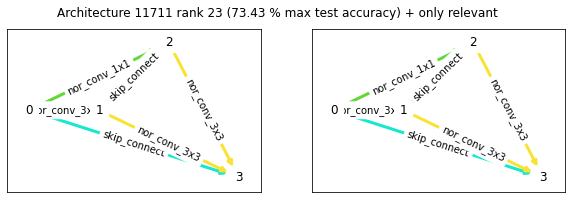

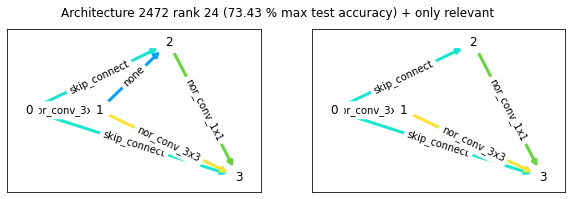

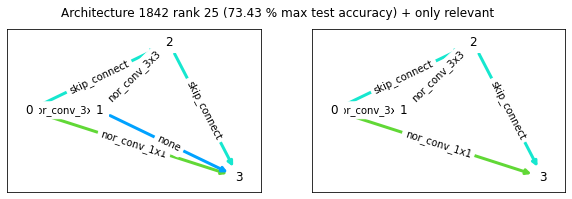

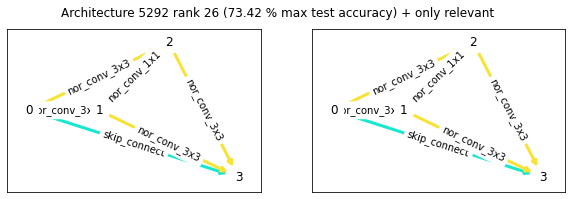

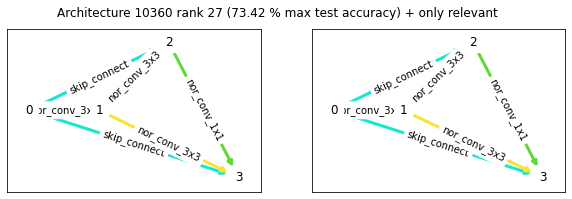

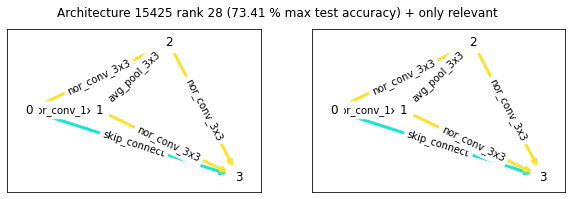

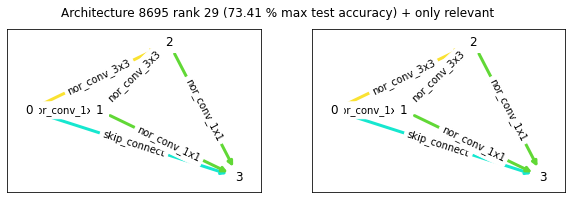

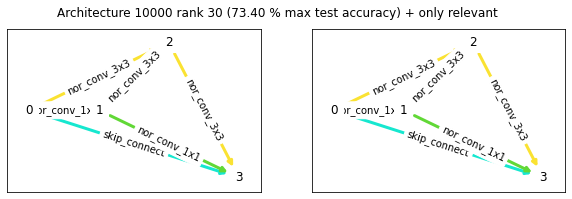

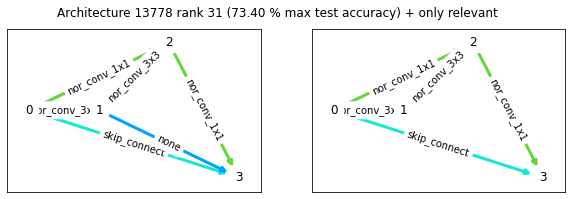

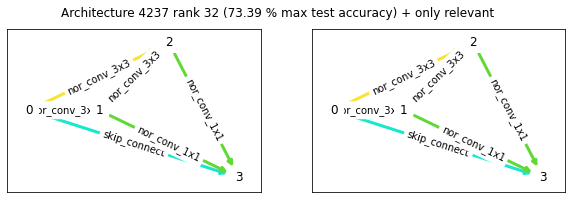

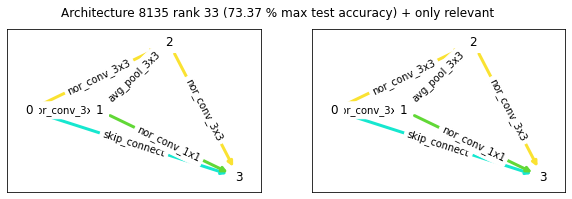

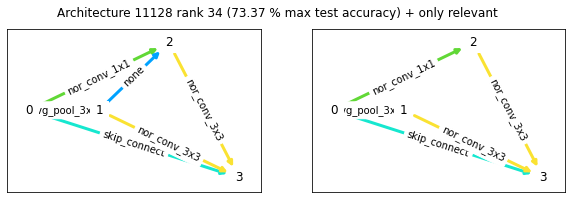

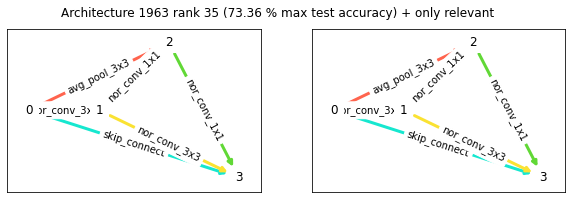

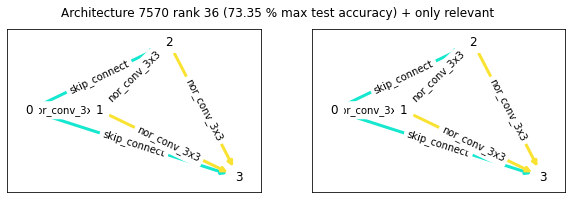

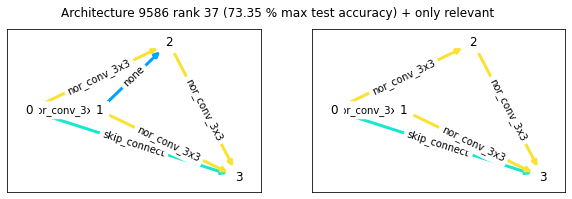

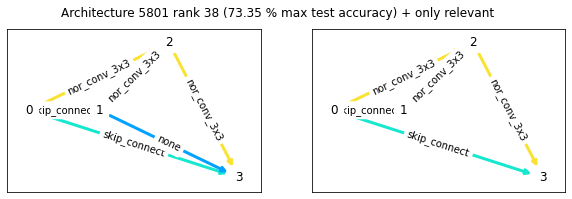

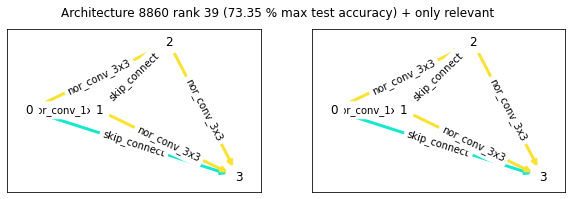

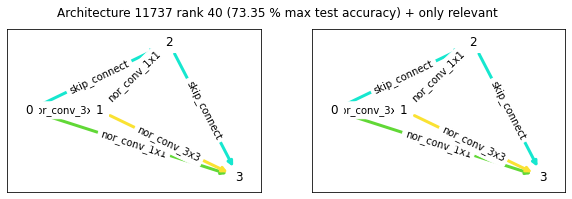

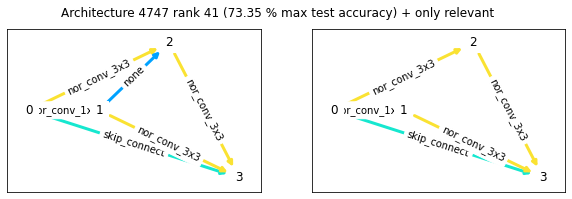

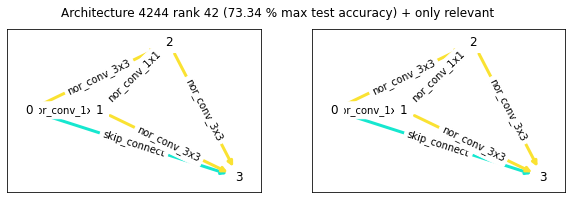

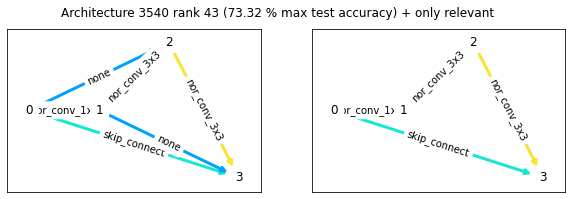

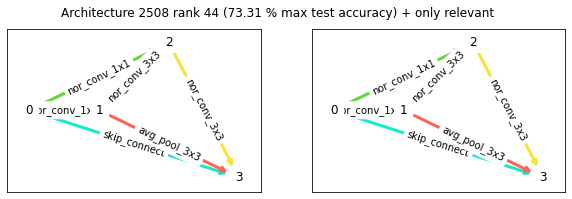

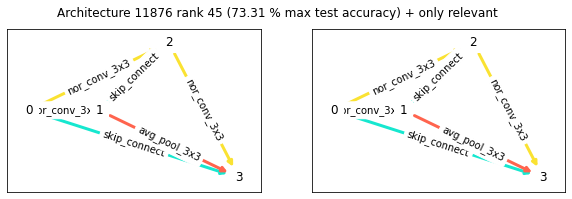

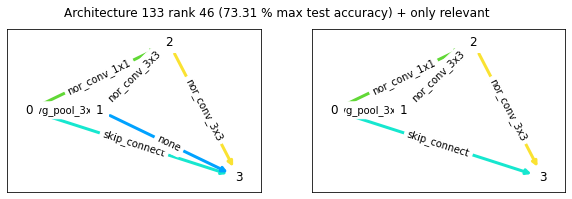

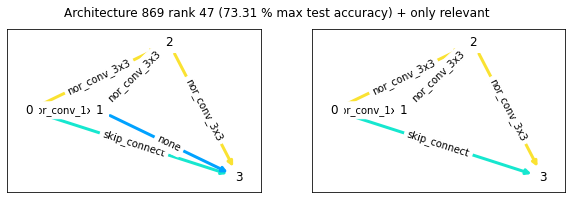

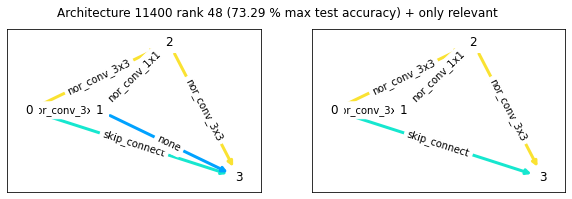

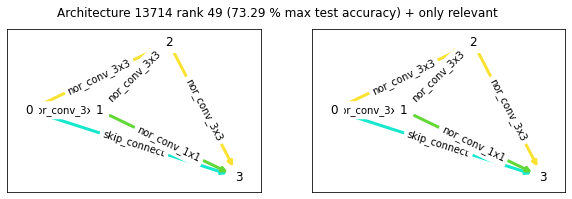

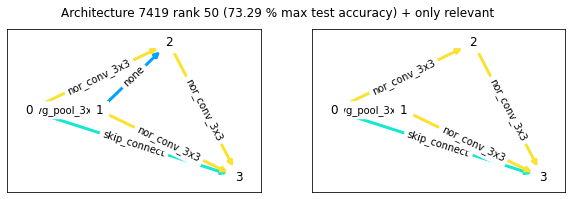

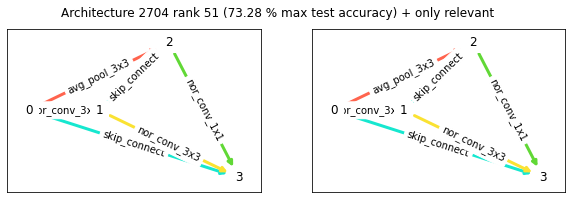

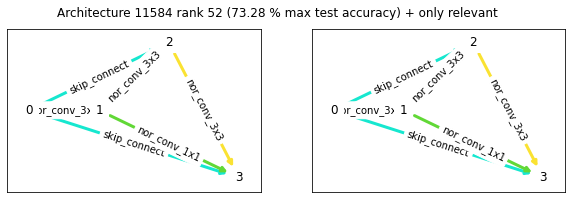

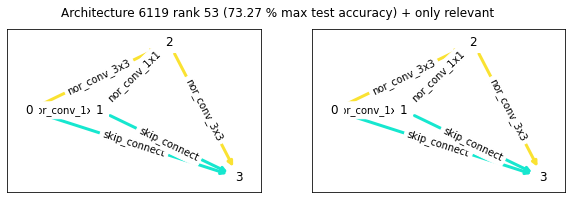

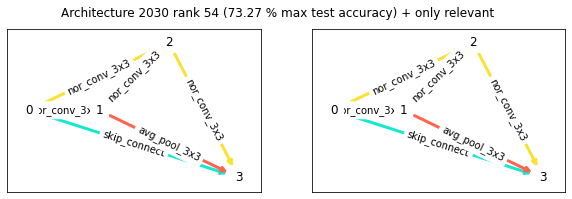

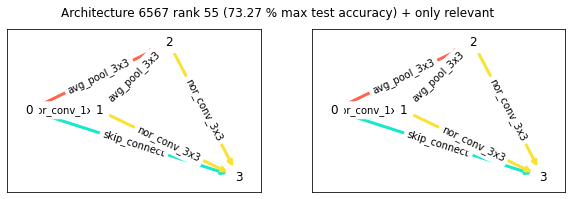

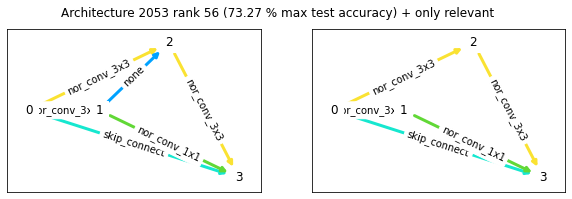

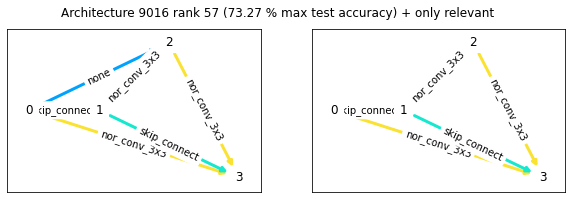

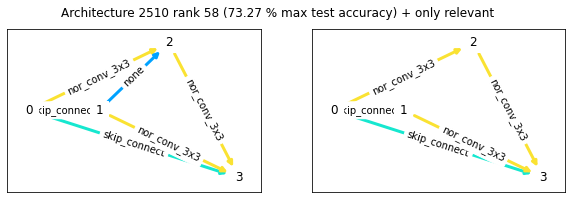

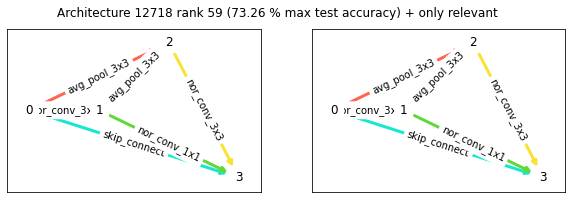

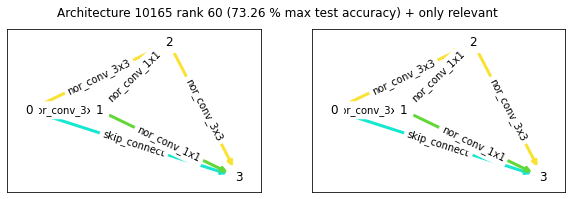

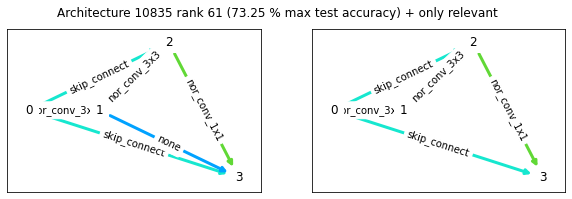

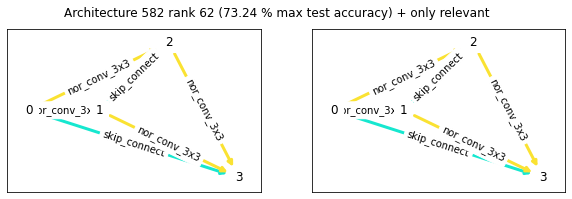

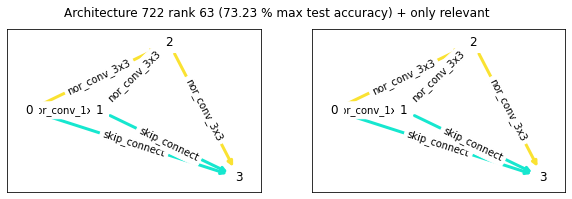

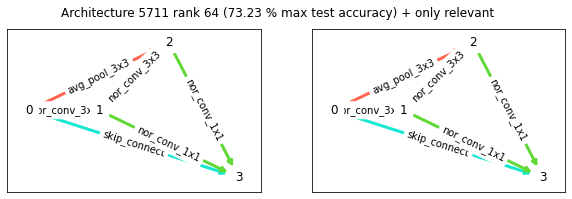

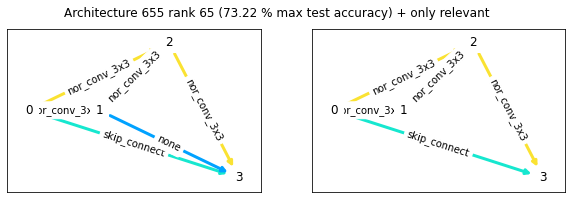

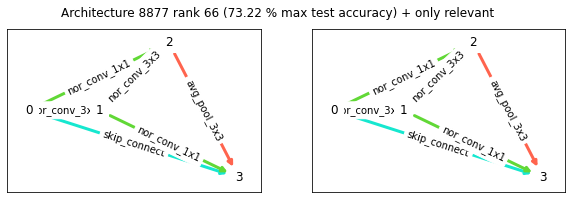

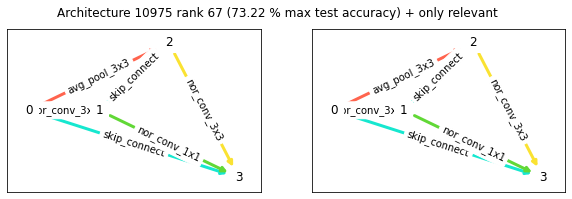

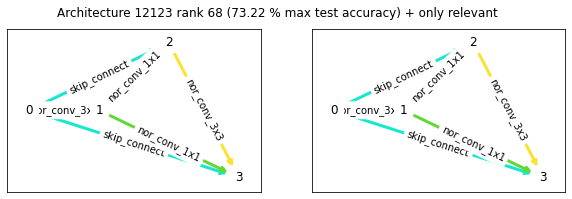

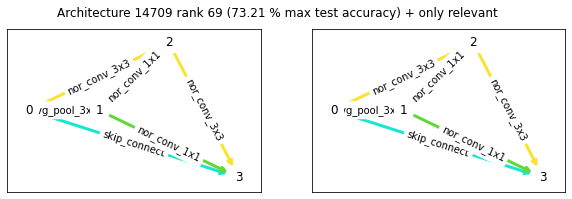

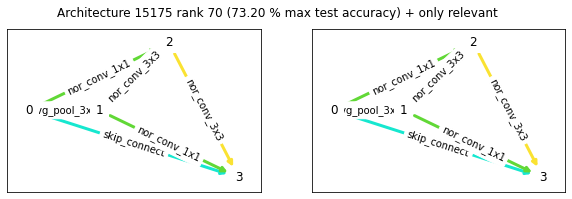

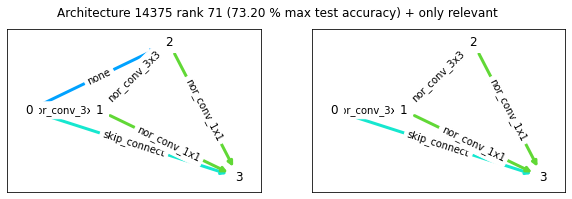

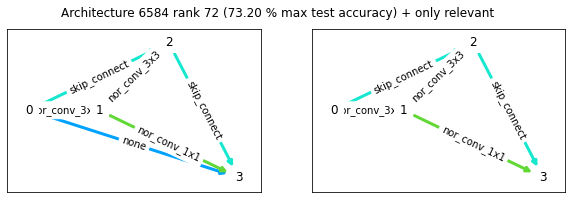

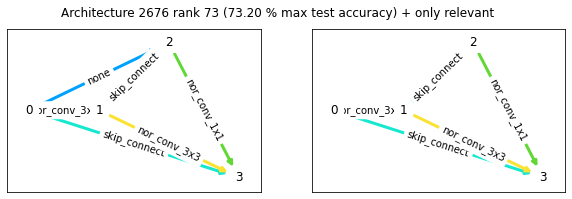

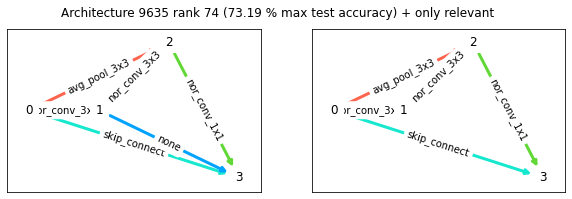

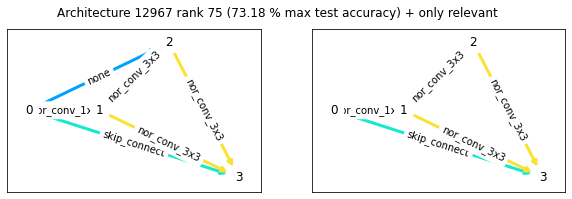

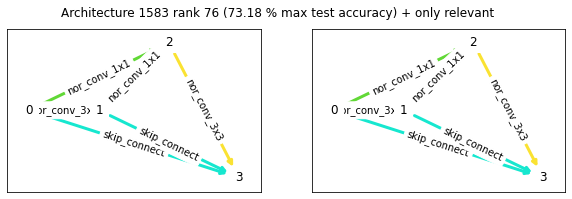

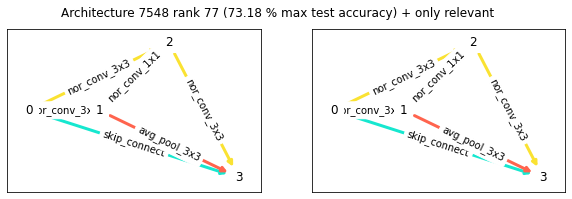

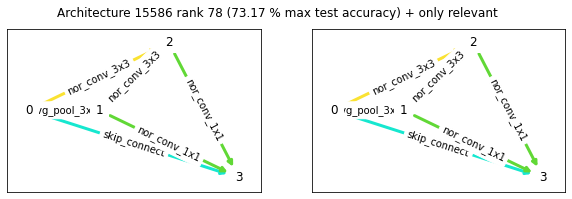

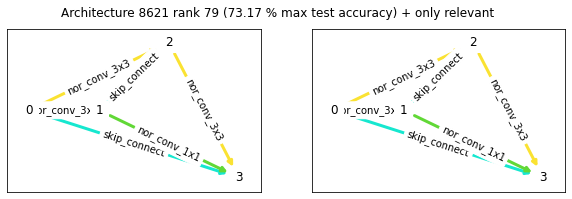

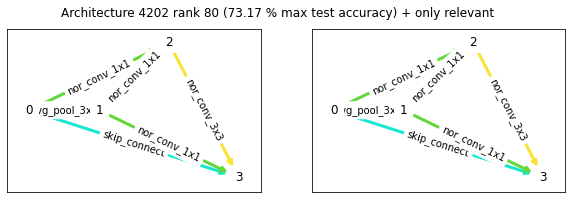

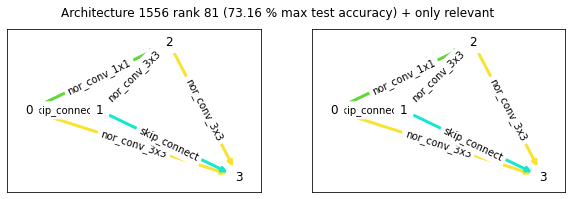

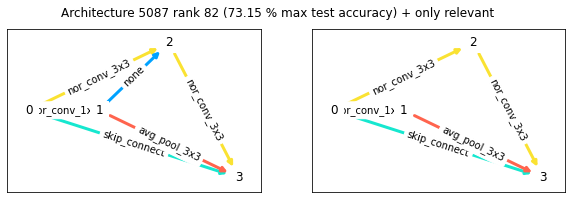

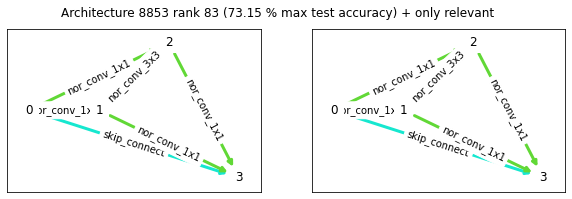

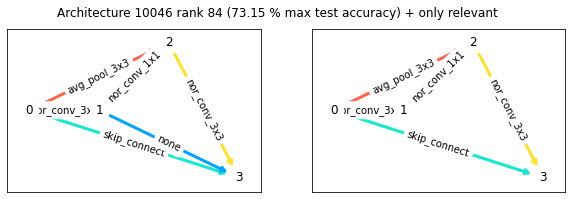

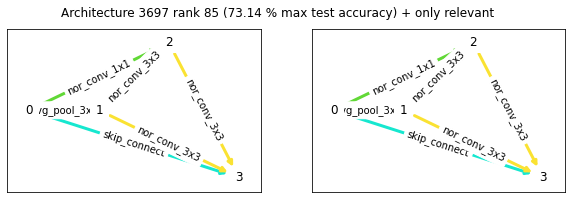

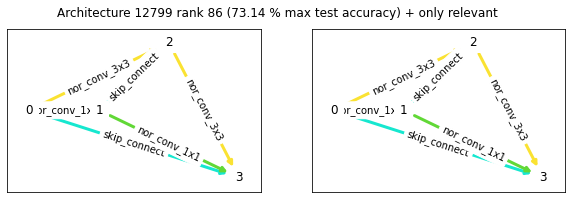

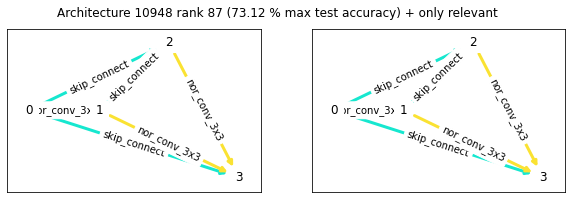

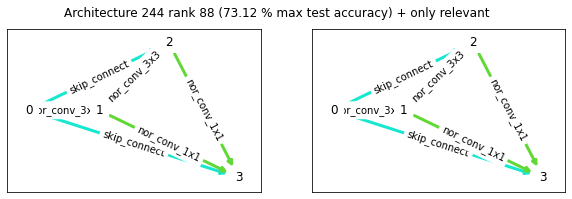

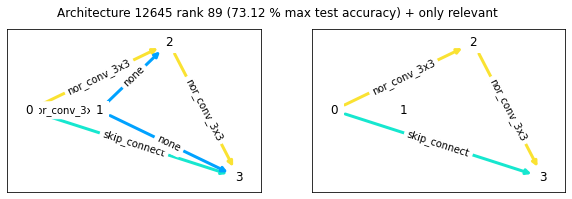

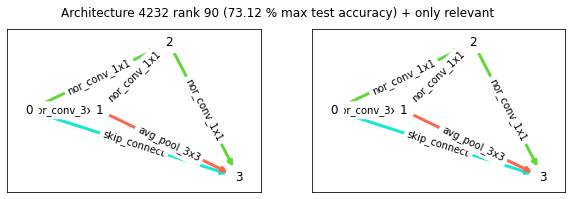

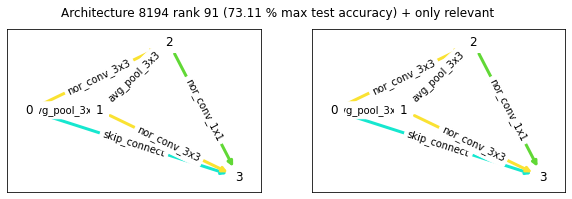

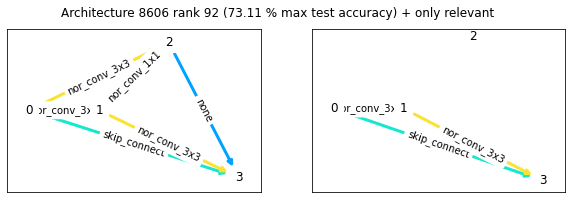

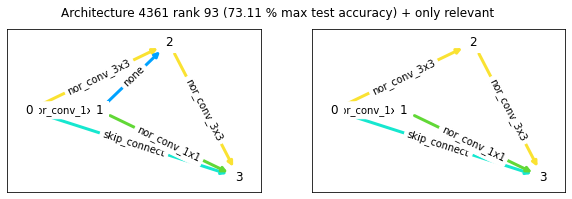

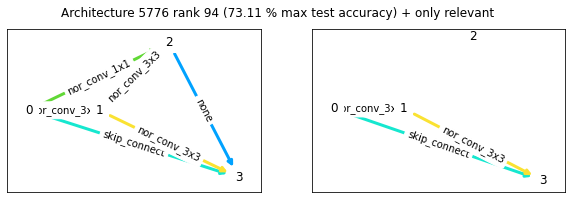

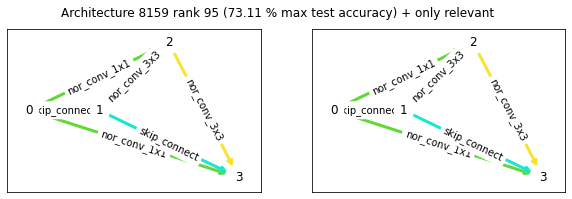

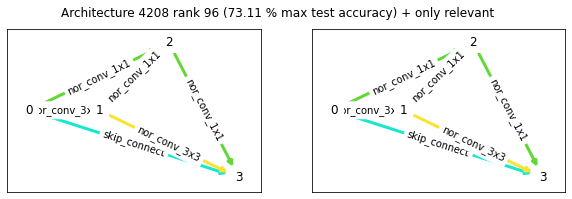

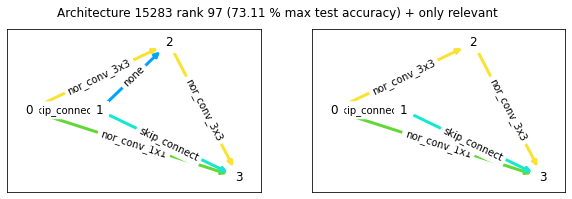

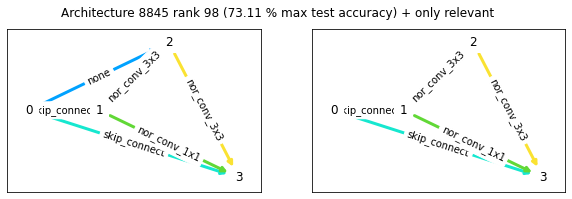

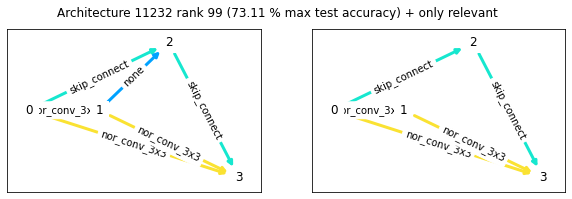

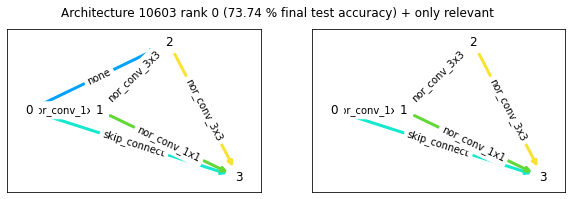

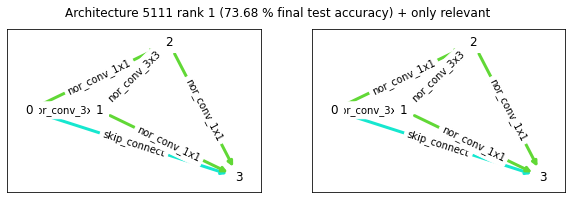

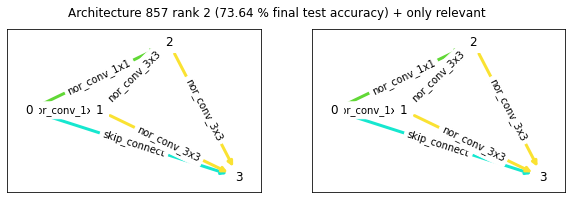

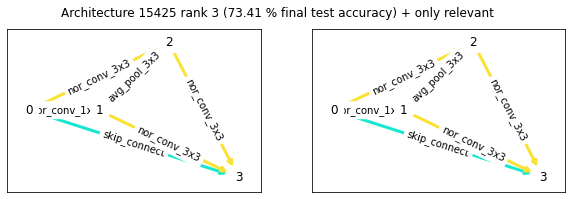

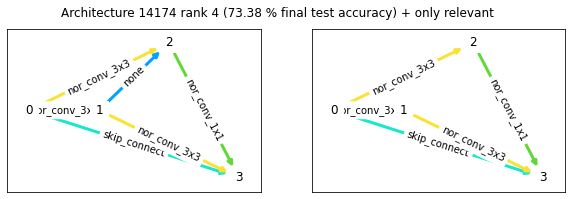

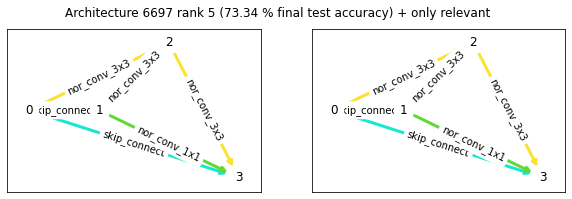

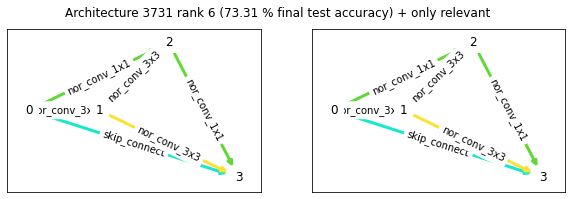

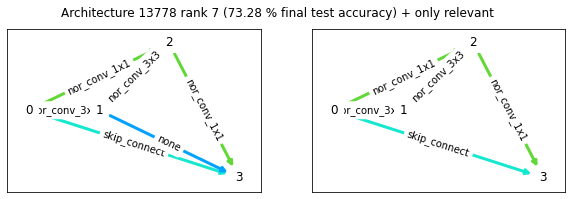

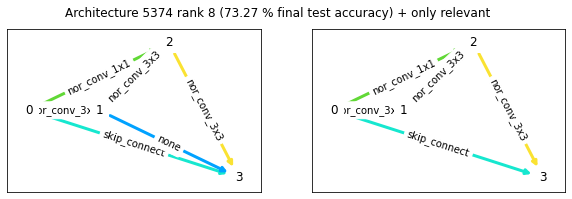

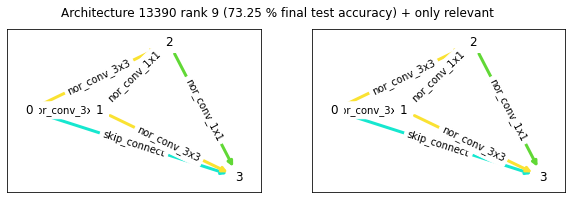

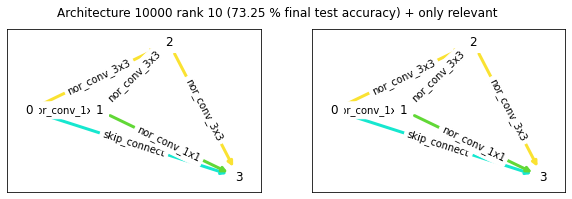

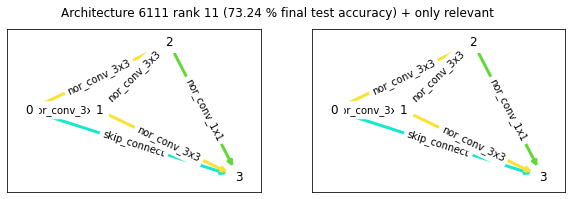

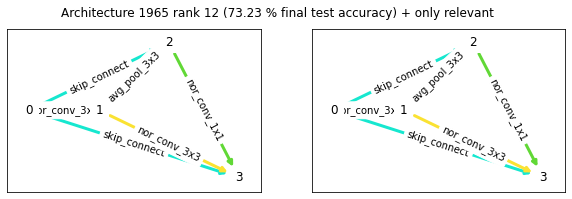

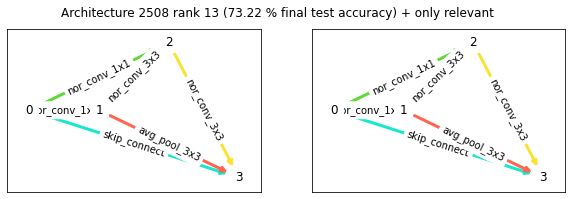

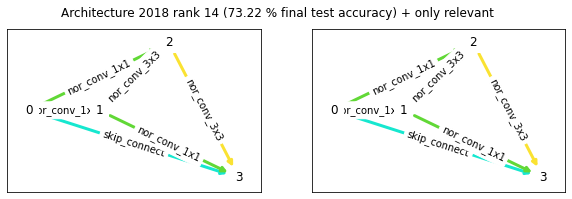

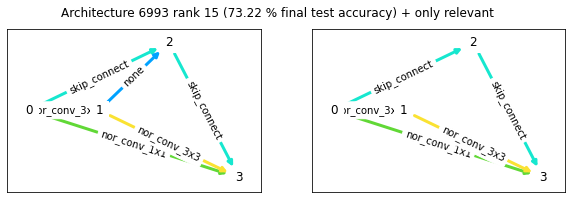

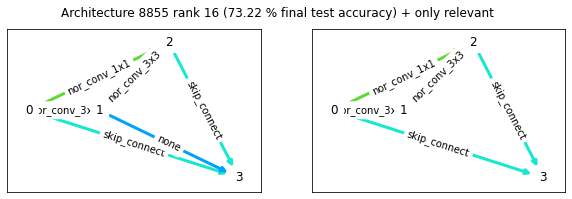

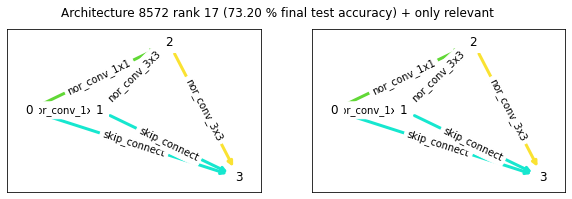

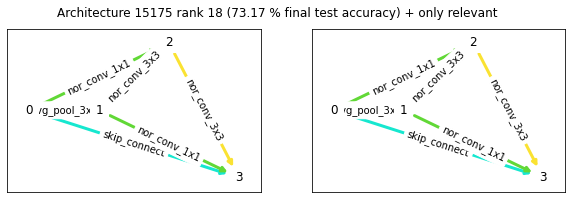

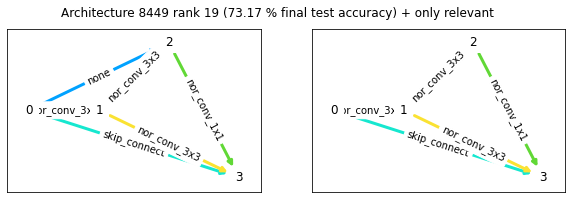

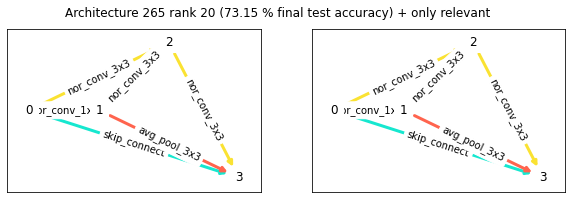

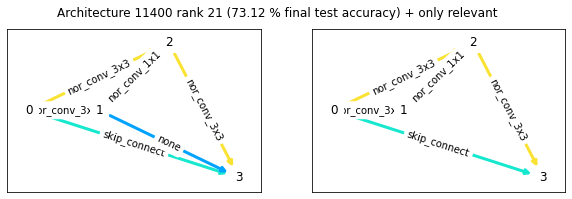

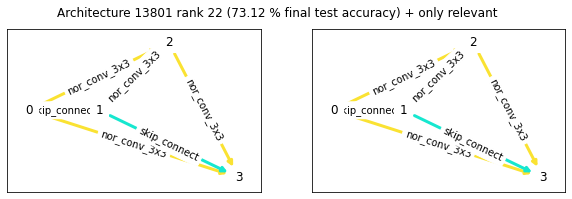

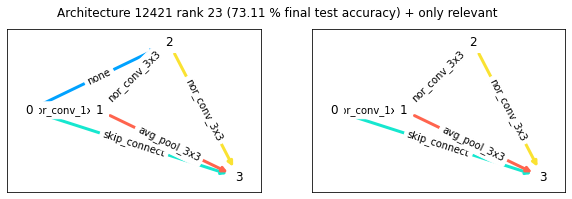

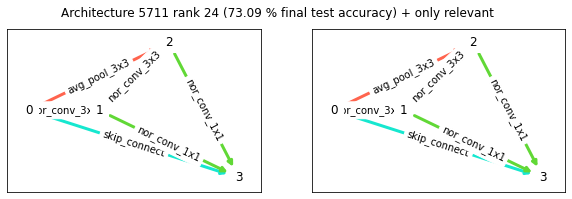

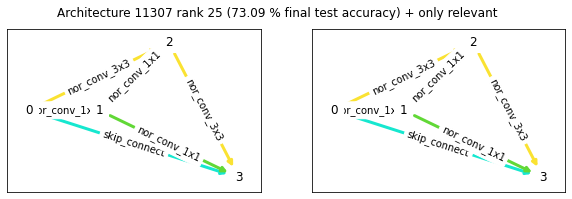

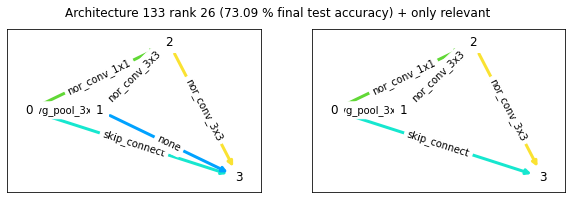

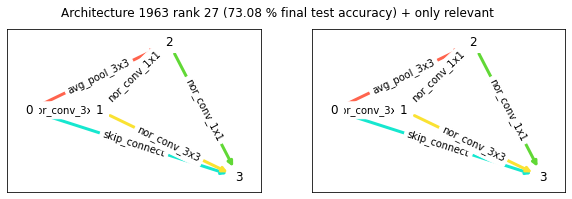

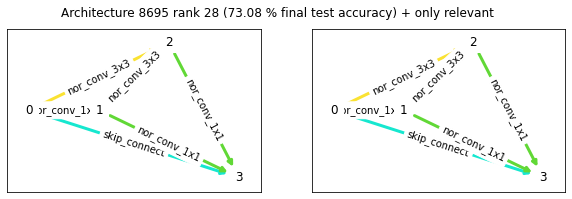

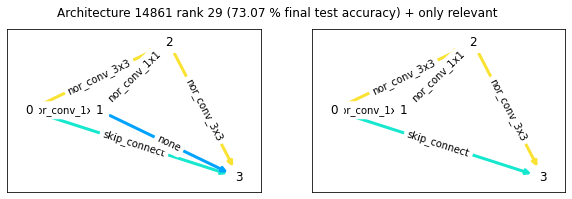

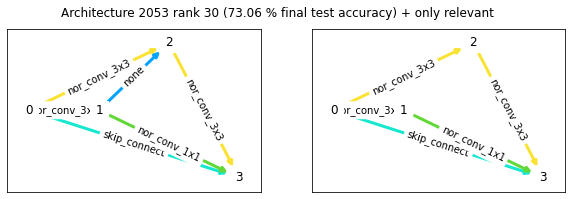

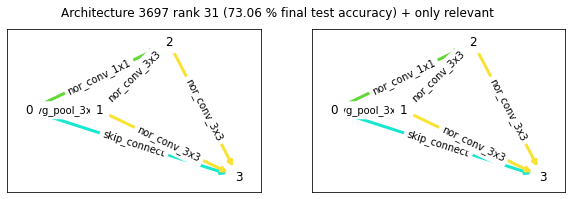

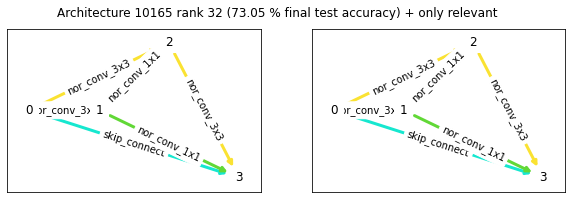

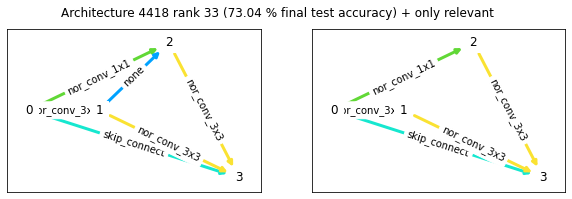

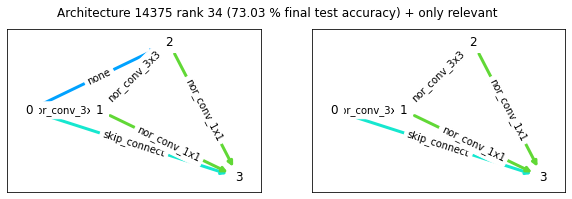

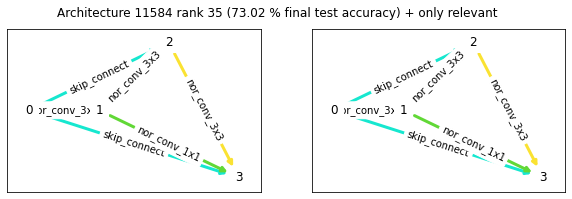

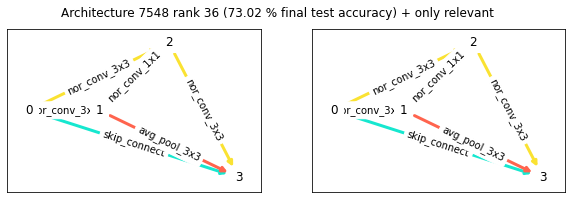

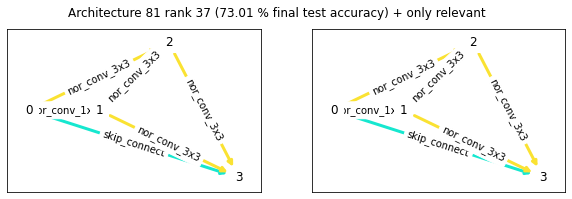

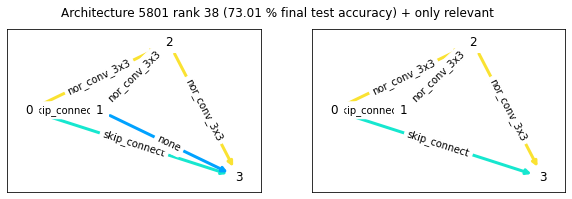

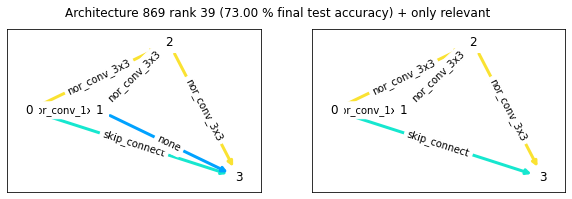

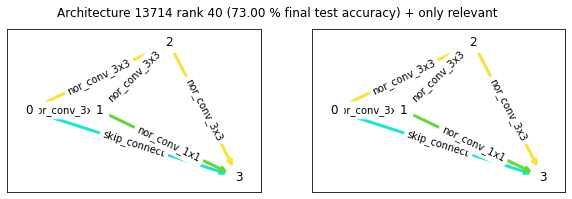

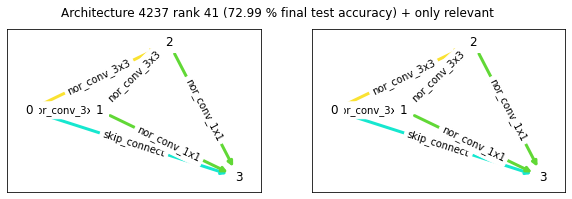

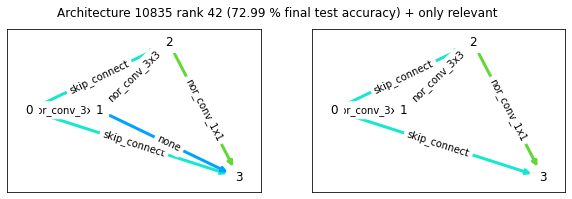

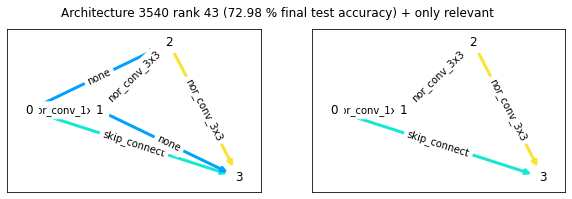

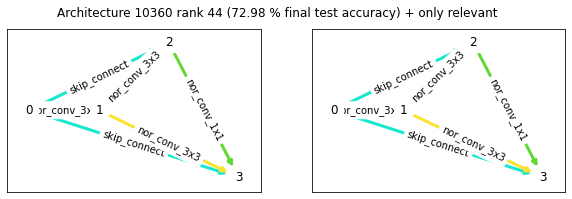

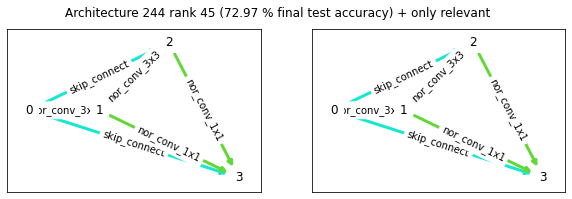

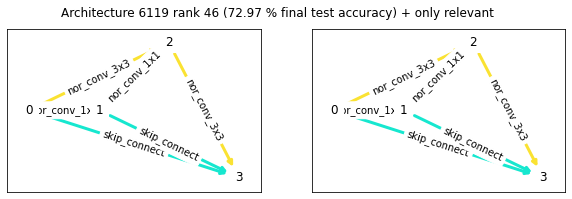

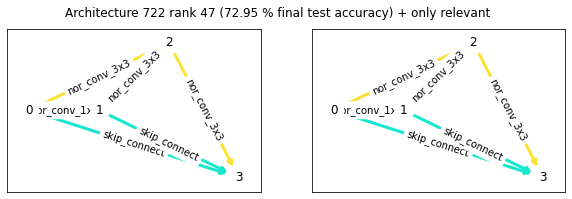

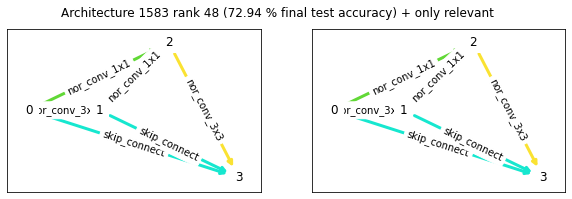

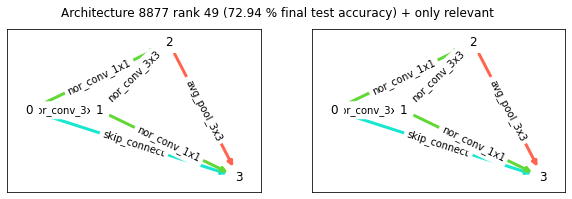

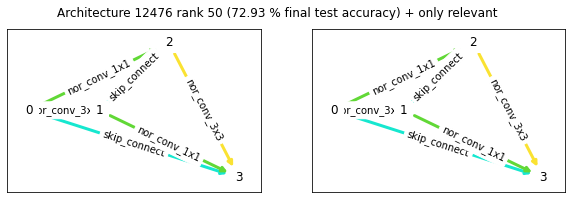

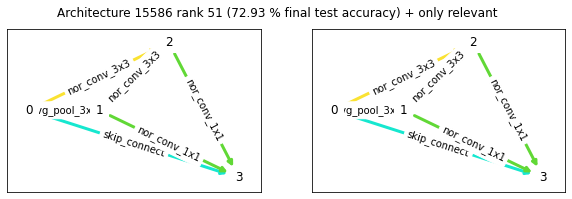

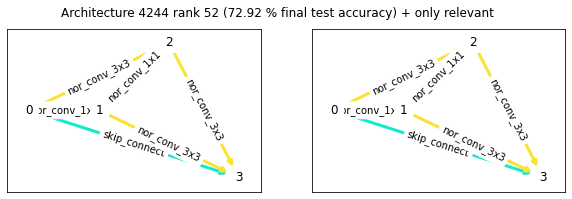

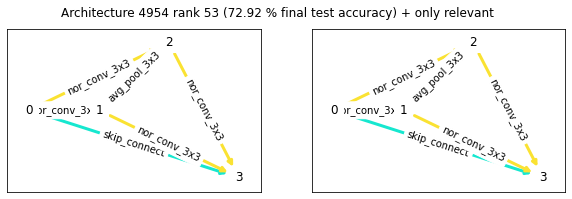

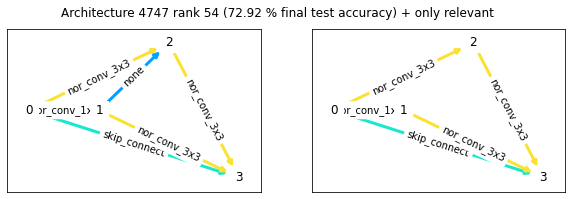

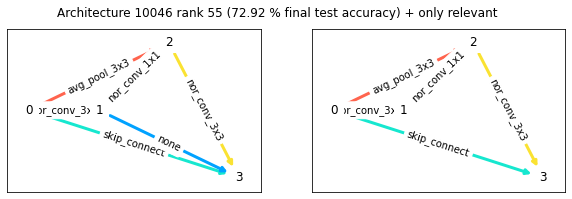

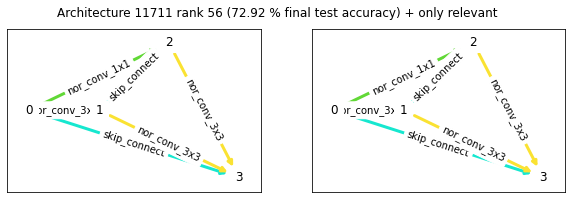

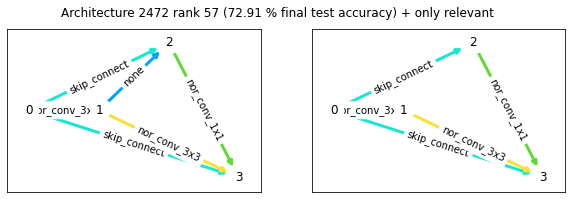

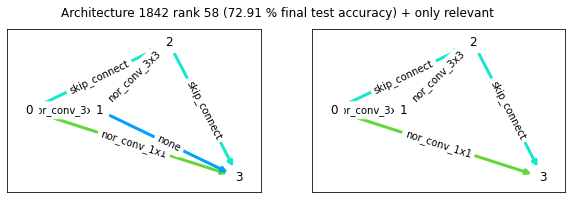

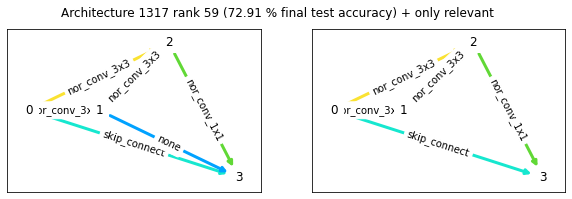

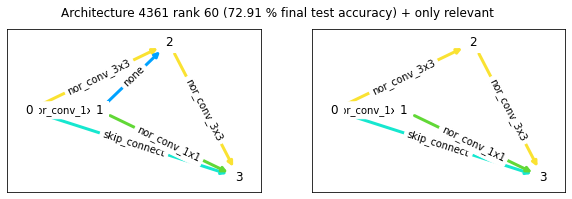

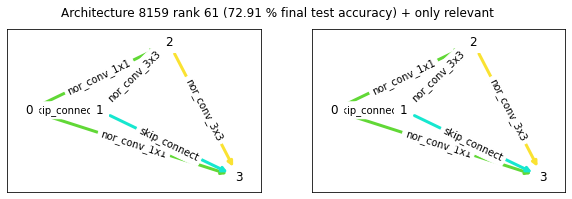

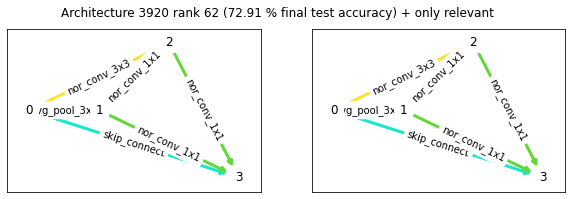

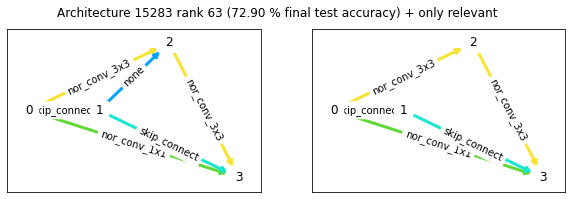

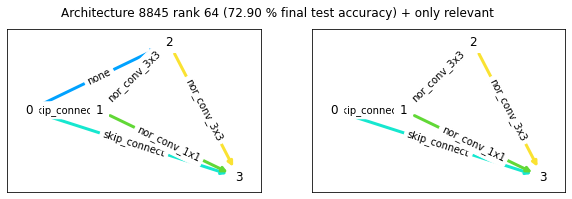

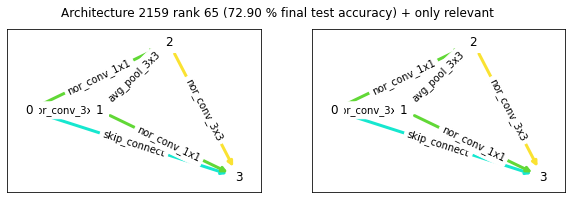

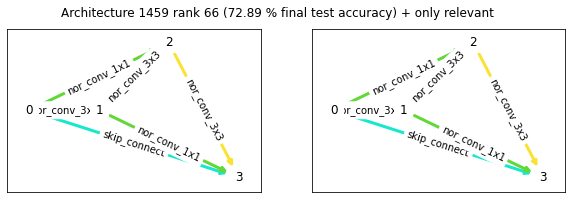

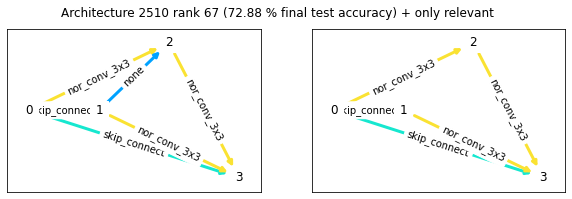

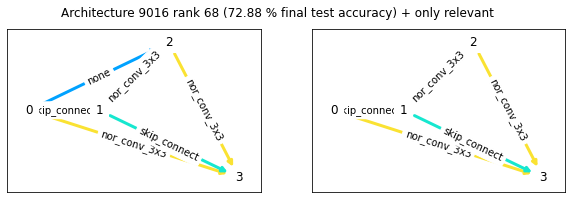

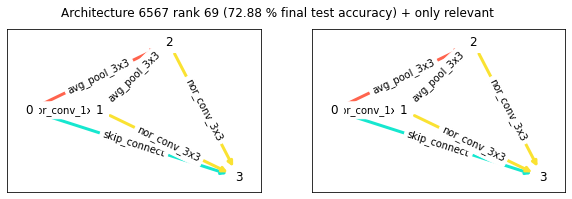

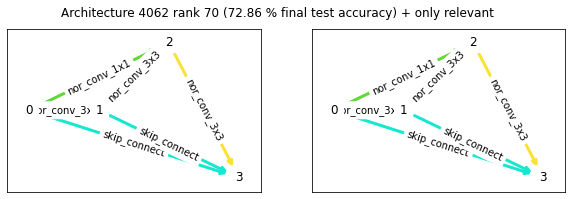

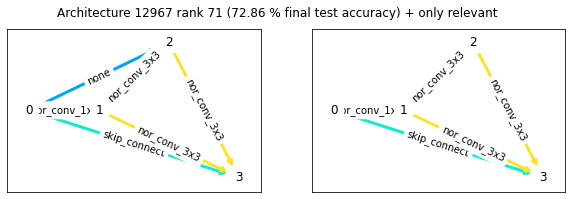

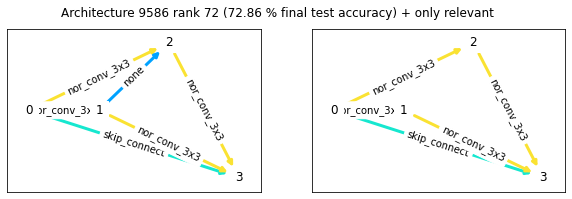

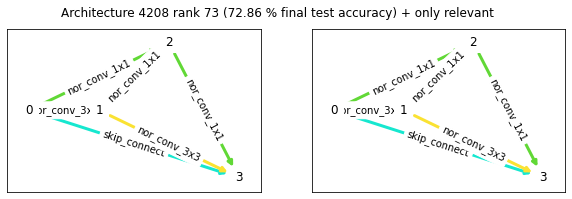

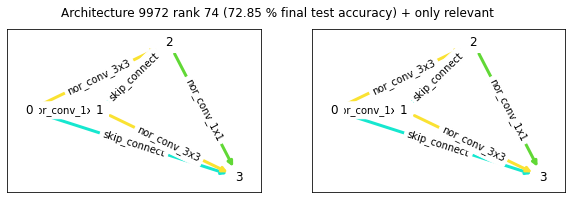

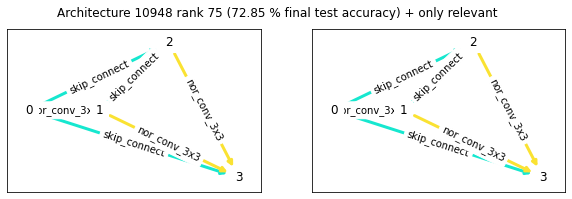

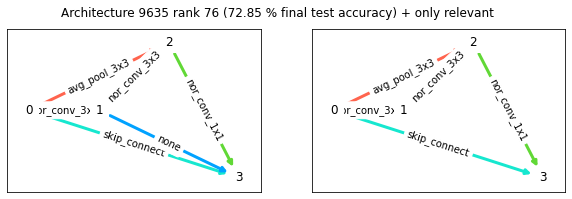

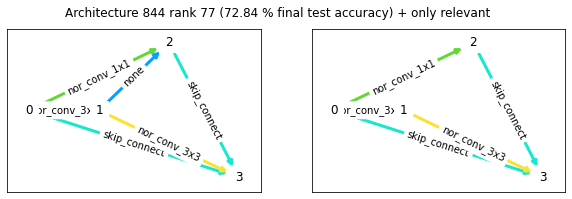

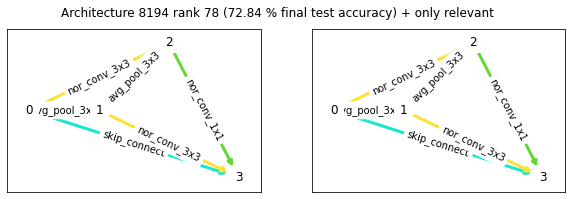

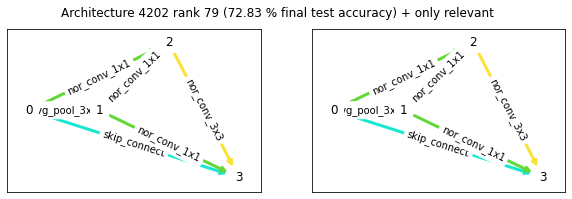

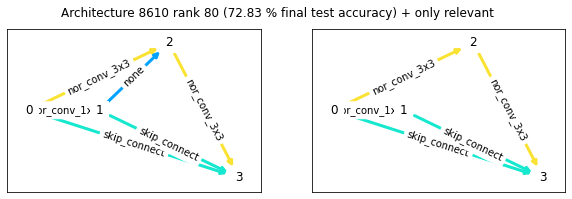

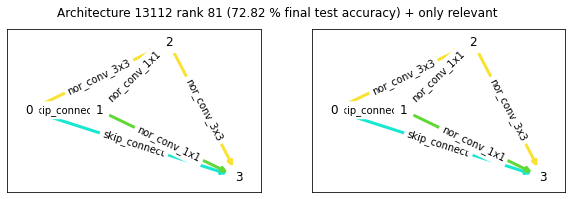

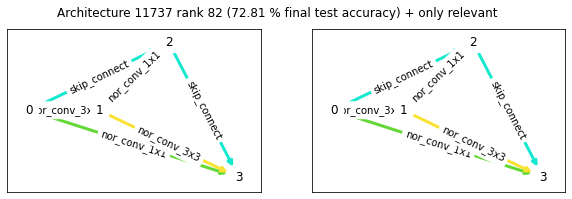

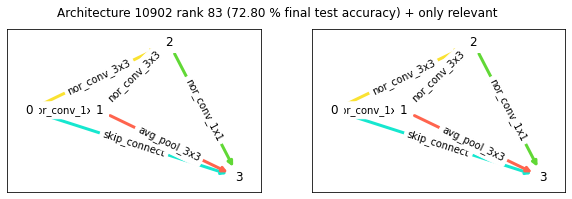

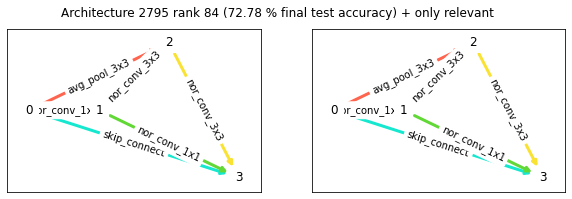

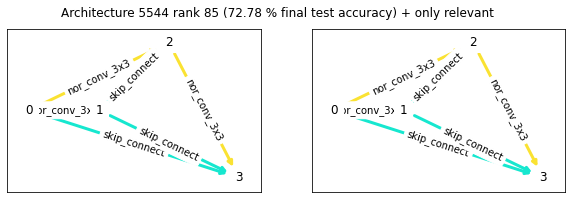

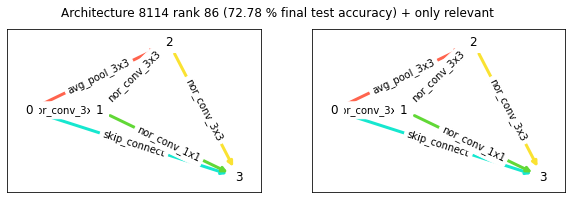

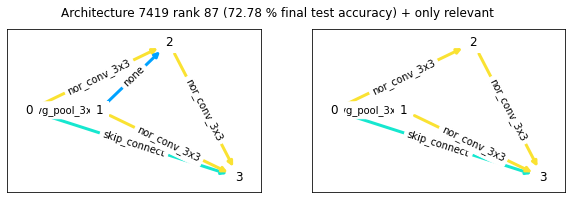

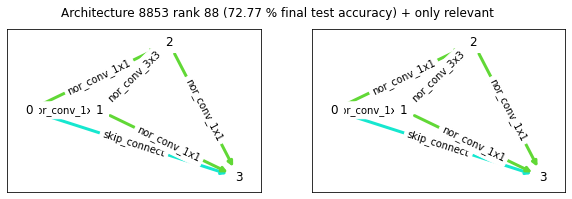

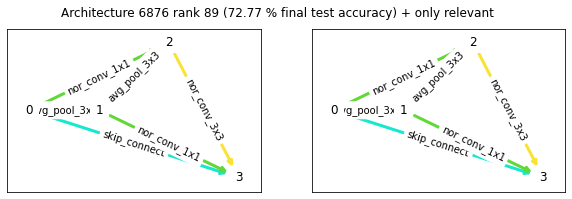

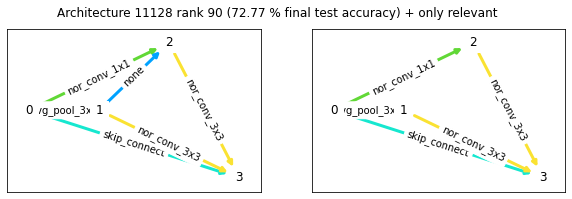

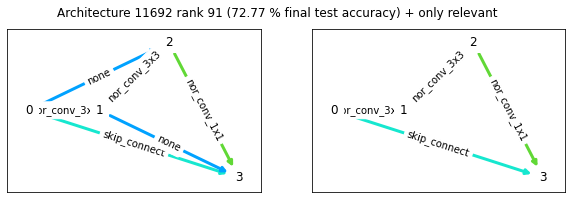

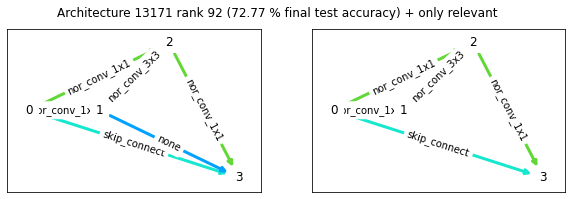

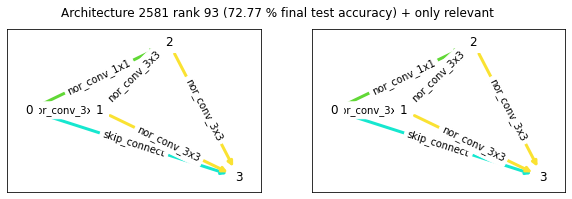

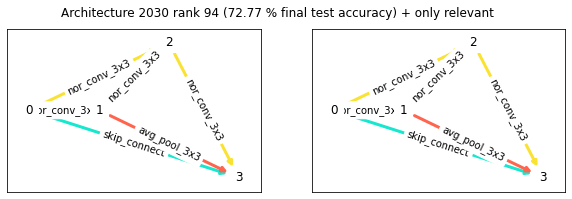

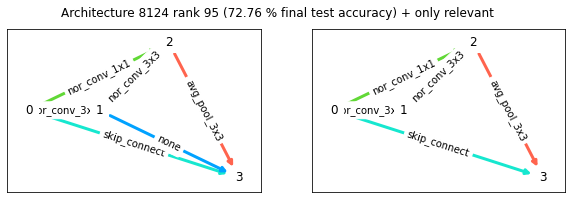

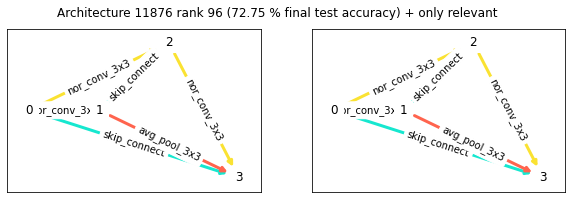

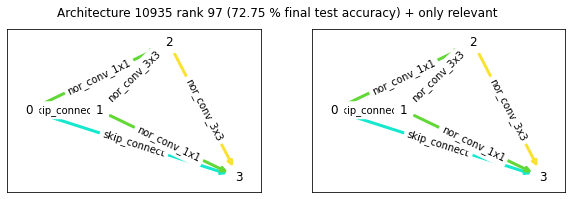

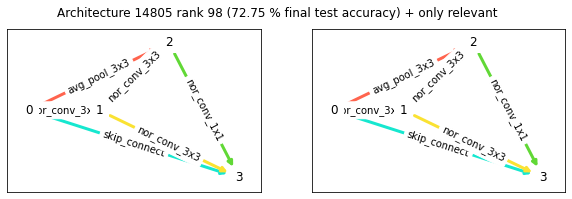

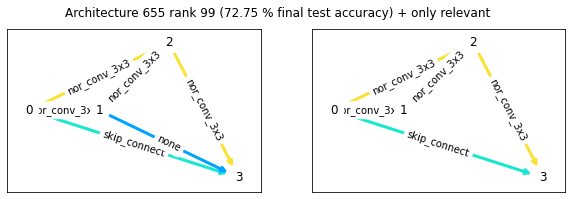

In [48]:
# draw top 100 archs + reduce to relevant graph
# import networkx as nx
data_type = 'test'
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    # mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type][::-1]
    mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
    counter = 0
    for index in np.nditer(mean_sorted_ids[:100], order='C'):  # actually :top_N
        data_dict = all_data[index]
        architecture_string = data_dict[dataset_name]['200']['additional_information']['arch_str']
        edge_label, edge_colors = get_edge_labels_and_colors(architecture_string)
        # plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        plt.sca(axs[0])
        nx.draw_networkx(G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                         edge_color=edge_colors, width=3)
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_label, font_color='black', font_size=10)

        plt.sca(axs[1])
        new_G = nx.DiGraph()
        nodes = np.arange(0, 4).tolist()
        new_G.add_nodes_from(nodes)
        relevant_edges = reduce_to_relevant_graph(edge_label)
        new_G.add_edges_from(relevant_edges.keys())
        new_edge_colors = get_color_array_for_edge_dict(relevant_edges)
        nx.draw_networkx(new_G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                         edge_color=new_edge_colors, width=3)
        nx.draw_networkx_edge_labels(new_G, pos=pos, edge_labels=relevant_edges, font_color='black', font_size=10)
        acc_of_arch = acc_dict[acc_type]['mean'][data_type][index]
        fig.suptitle(f"Architecture {index} rank {counter} ({acc_of_arch:.2f} % {prefix_type} test accuracy) + only relevant")
        # save best 10 final architectures
        # if prefix_type == 'final' and counter < 10:
        #     plt.savefig(f"{data_set_prefix}_final_{counter}.pdf", facecolor='w')
        counter += 1
        plt.show()

In [49]:
# analyse architectures
# def return_all_skip_archs():
#     all_skip_archs = []
#     for index in range(len(all_data)):
#         if has_architecture_skip_connection_path(index):
#             all_skip_archs.append(index)
#     return all_skip_archs


def return_skip_archs_for_index_array(arr):
    skip_archs = []
    for index in arr:
        if has_architecture_skip_connection_path(index):
            skip_archs.append(index)
    return skip_archs


def has_arch_conv_path_by_index(index):
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    return has_path_with_conv(edge_dict)


def has_arch_avg_path_by_index(index):
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    return has_path_with_avg(edge_dict)


def has_conv_path_without_avg(edge_dict):
    test_edge_dict = edge_dict.copy()
    for edge_id in test_edge_dict:
        edge = edge_dict[edge_id]
        if edge == avg_fullstring:
            test_edge_dict[edge_id] = no_path_string
    return has_path_with_conv(test_edge_dict)


check_top_n = 5208

# print(f'Top {check_top_n}')
# for prefix_type in ['max', 'final']:
#     acc_type = prefix_type + '_acc'
#     mean_acc_type = 'mean_' + acc_type
#     mean_sorted_ids = acc_dict_sorted_ids[mean_acc_type][data_type]
#     count_has_skip_connections = sum(map(has_architecture_skip_connection_path, np.nditer(mean_sorted_ids[:check_top_n], order='C')))
#     print(f'{prefix_type.capitalize()} accuracy: {count_has_skip_connections}')
# print()
for is_best in [True, False]:
    if is_best:
        print(f'Top {check_top_n}')
    else:
        print(f'Worst {check_top_n}')
    for prefix_type in ['max', 'final']:
        acc_type = prefix_type + '_acc'
        if is_best:
            mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
        else:
            mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type][::-1]
        arr = np.nditer(mean_sorted_ids[:check_top_n], order='C')
        # # return middle third
        # arr = np.nditer(mean_sorted_ids[5208:-5208], order='C')
        has_skip_connection_arr = return_skip_archs_for_index_array(arr)
        count_has_skip_connections = len(has_skip_connection_arr)
        # count_has_skip_connections = sum(map(has_architecture_skip_connection_path, np.nditer(mean_sorted_ids[:check_top_n], order='C')))
        print(f'{prefix_type.capitalize()} accuracy: Has skip_connect path: {count_has_skip_connections}')
        has_skip_and_conv = []
        has_skip_and_avg = []
        count_only_skip = 0
        for index in has_skip_connection_arr:
            if has_arch_conv_path_by_index(index):
                has_skip_and_conv.append(index)
            if has_arch_avg_path_by_index(index):
                has_skip_and_avg.append(index)
            if index in skip_arch_ids:
                count_only_skip += 1
        for index in has_skip_and_conv:
            architecture_string = get_architecture_string_by_index(index)
            # print(get_edge_dict(architecture_string))
        print(f'{prefix_type.capitalize()} accuracy: Has only one skip_connect path: {count_only_skip}')
        print(f'{prefix_type.capitalize()} accuracy: Has skip_connect path and conv: {len(has_skip_and_conv)}')
        print(f'{prefix_type.capitalize()} accuracy: Has skip_connect path and avg: {len(has_skip_and_avg)}')
        if is_best:
            for arch_id in has_skip_and_avg:
                architecture_string = get_architecture_string_by_index(arch_id)
                rank = np.where(mean_sorted_ids == arch_id)[0][0]
                edge_dict = get_edge_dict(architecture_string)
                has_path = has_conv_path_without_avg(edge_dict)
                if not has_path:
                    title = f'Arch_id:{arch_id}, {prefix_type.capitalize()} accuracy rank:{rank}, has_path:{has_path}'
                    # draw_graph_from_architecture_string(architecture_string, title=title)

Top 5208
Max accuracy: Has skip_connect path: 2154
Max accuracy: Has only one skip_connect path: 0
Max accuracy: Has skip_connect path and conv: 2154
Max accuracy: Has skip_connect path and avg: 1142
Final accuracy: Has skip_connect path: 2224
Final accuracy: Has only one skip_connect path: 0
Final accuracy: Has skip_connect path and conv: 2224
Final accuracy: Has skip_connect path and avg: 1207
Worst 5208
Max accuracy: Has skip_connect path: 1036
Max accuracy: Has only one skip_connect path: 400
Max accuracy: Has skip_connect path and conv: 200
Max accuracy: Has skip_connect path and avg: 544
Final accuracy: Has skip_connect path: 879
Final accuracy: Has only one skip_connect path: 400
Final accuracy: Has skip_connect path and conv: 175
Final accuracy: Has skip_connect path and avg: 428


In [50]:


# for check_top_n in [100, 341, 500, 1000, 3000, 5000]:

for check_top_n in [5208]:
    for is_best in [True,False]:
    # for is_best in [False]:
        if is_best:
            print(f'Top {check_top_n}')
        else:
            print(f'Worst {check_top_n}')
        for prefix_type in ['max', 'final']:
            acc_type = prefix_type + '_acc'
            if is_best:
                mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
            else:
                mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type][::-1]

            for edge_type in [conv_substring, avg_substring, skip_connection_string, 'nor_conv_1x1', 'nor_conv_3x3',
                              'empty']:
                get_all_with_edge_type = []

                arr = np.nditer(mean_sorted_ids[:check_top_n], order='C')
                # # return middle third
                # arr = np.nditer(mean_sorted_ids[5208:-5208], order='C')
                for index in arr:
                    architecture_string = get_architecture_string_by_index(index)
                    edge_dict = get_edge_dict(architecture_string)
                    relevant_edges = reduce_to_relevant_graph(edge_dict)
                    if edge_type == 'empty':
                        if len(relevant_edges) == 0:
                            get_all_with_edge_type.append(index)
                    else:
                        if has_path_with_substring(relevant_edges, edge_type):
                            get_all_with_edge_type.append(index)
                            # if relevant_edges == avg_substring and not has_path_with_conv(relevant_edges):
                            #     draw_graph_from_architecture_string(architecture_string, with_relevant=True, title=index)
                            if edge_type == conv_substring:
                                # print('conv')
                                real_rank = mean_sorted_ids[::-1]
                                rank = np.where(real_rank == index)[0][0]
                                # draw_graph_from_architecture_string(architecture_string, with_relevant=True,
                                #                                     title=f'index: {index}, rank: {rank}')
                if edge_type != 'empty':
                    print(
                        f'{prefix_type.capitalize()} accuracy: Include "{edge_type}" in a path: {len(get_all_with_edge_type)}')
                    if edge_type == avg_substring:
                        avg_but_not_conv = []
                        for index in get_all_with_edge_type:
                            architecture_string = get_architecture_string_by_index(index)
                            edge_dict = get_edge_dict(architecture_string)
                            relevant_edges = reduce_to_relevant_graph(edge_dict)
                            if not has_path_with_conv(relevant_edges):
                                avg_but_not_conv.append(index)
                        print(
                            f'{prefix_type.capitalize()} accuracy: Include "{edge_type}" but not conv: {len(avg_but_not_conv)}')
                else:
                    print(
                        f'{prefix_type.capitalize()} accuracy: Graph has no path (every path include "{no_path_string}"): {len(get_all_with_edge_type)}')


Top 5208
Max accuracy: Include "conv" in a path: 5208
Max accuracy: Include "avg" in a path: 3965
Max accuracy: Include "avg" but not conv: 0
Max accuracy: Include "skip_connect" in a path: 4244
Max accuracy: Include "nor_conv_1x1" in a path: 3906
Max accuracy: Include "nor_conv_3x3" in a path: 4328
Max accuracy: Graph has no path (every path include "none"): 0
Final accuracy: Include "conv" in a path: 5208
Final accuracy: Include "avg" in a path: 4001
Final accuracy: Include "avg" but not conv: 0
Final accuracy: Include "skip_connect" in a path: 4178
Final accuracy: Include "nor_conv_1x1" in a path: 4026
Final accuracy: Include "nor_conv_3x3" in a path: 4108
Final accuracy: Graph has no path (every path include "none"): 0
Worst 5208
Max accuracy: Include "conv" in a path: 3232
Max accuracy: Include "avg" in a path: 2794
Max accuracy: Include "avg" but not conv: 1175
Max accuracy: Include "skip_connect" in a path: 2463
Max accuracy: Include "nor_conv_1x1" in a path: 2134
Max accuracy: 

NTU RGB+D
Top 15625 & max & conv & 1983 & 3842 & 4272 & 3288 & 1664 & 512 & 64 \\\hline
Top 15625 & max & 1x1 conv & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Top 15625 & max & 3x3 conv & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Top 15625 & max & avg & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Top 15625 & final & conv & 1983 & 3842 & 4272 & 3288 & 1664 & 512 & 64 \\\hline
Top 15625 & final & 1x1 conv & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Top 15625 & final & 3x3 conv & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Top 15625 & final & avg & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Worst 15625 & max & conv & 1983 & 3842 & 4272 & 3288 & 1664 & 512 & 64 \\\hline
Worst 15625 & max & 1x1 conv & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Worst 15625 & max & 3x3 conv & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Worst 15625 & max & avg & 5504 & 5792 & 3100 & 1007 & 199 & 22 & 1 \\\hline
Worst 15625 & final & conv & 1983 & 3842 & 4

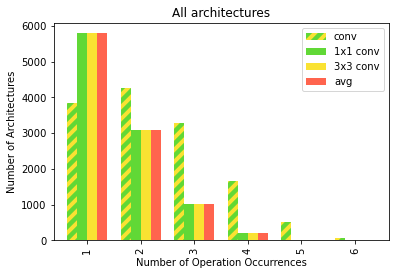

In [51]:

def get_number_of_substring(index, substring=conv_substring):
    # def has_arch_avg_path_by_index(index):
    counter = 0
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    relevant_edge_dict = reduce_to_relevant_graph(edge_dict)
    for edge_idx in relevant_edge_dict:
        edge = relevant_edge_dict[edge_idx]
        if substring in edge:
            counter += 1
    return counter

def count_archs_with_substring_for_index_array(arr, substring=conv_substring):
    # def return_skip_archs_for_index_array(arr):
    number_list=[]
    # count how many architectures have 0 to 6 edges with the substring
    for index in arr:
        number_list.append(get_number_of_substring(index, substring))
        bins = range(8)
    counts, bins = np.histogram(number_list, bins=bins)
    # print(number_list)
    return counts

plt.rcParams['hatch.color'] = "#FAE232"
plt.rcParams["hatch.linewidth"] = 4
Path(f"./comparison/{data_set_prefix}").mkdir(parents=True, exist_ok=True)

data_type = 'test'
print(data_set_name_thesis)
for number in [15625]:
# for number in [100, 1000, 3000, 5208, 5209]:
    for best_worst in [1,-1]:
        if best_worst > 0:
            prefix_string = 'Top'
        else:
            prefix_string = 'Worst'
        bar_x = []
        bar_y = []
        color1s = []
        color2s = []
        test = {}
        # plotdata = pd.DataFrame({
        for prefix_type in ['max', 'final']:
            acc_type = prefix_type + '_acc'
            for substring in [conv_substring, "conv_1x1", "conv_3x3", avg_substring]:
                mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
                # to get middle 5209
                if 5209 <= number < 15625:
                    arr = np.nditer(mean_sorted_ids[5208:-5208], order='C')
                    start_text = "Middle 5209"
                else:
                    if best_worst > 0:
                        arr = np.nditer(mean_sorted_ids[:number], order='C')
                    else:
                        arr = np.nditer(mean_sorted_ids[(best_worst*number):], order='C')
                    start_text = f"{prefix_string} {number}"
                counts = count_archs_with_substring_for_index_array(arr, substring)
                if "conv_" in substring:
                    substring = substring[5:]+ " conv"
                test[substring] = counts[1:]
                for number_of_edges in range(1, len(counts)):
                    # print(number_of_edges)
                    # print(counts[number_of_edges])
                    if counts[number_of_edges] > 0:
                        # bar_x.append(f"{number_of_edges}x {substring}")
                        bar_x.append(f"{number_of_edges}")
                        bar_y.append(counts[number_of_edges])
                        # color1s.append(color1)
                        # color2s.append(color2)
                # print(counts)
                # print(list(zip(range(7), counts)))
                latex_table_row_tail = f"{start_text} & {prefix_type} & {substring} & " + " & ".join([str(i) for i in counts]) + " \\\\\\hline"
                print(latex_table_row_tail)
            plotdata = pd.DataFrame(test, index=["1", "2", "3", "4", "5", "6"])
            plt.close()
            # if number >= 5209:
            #     start_text = "Middle 5209"
            # else:
            #     start_text = f"{prefix_string} {number}"
            fig, ax = plt.subplots()
            plotdata.plot(ax=ax, kind="bar", color=["#61D836", '#61D836', '#FAE232', '#FF644E'], width=0.75)
            # plt.title(f"{data_set_name_thesis}: {start_text} architectures ({prefix_type} accuracy)")
            plt.title(f"All architectures")
            plt.xlabel("Number of Operation Occurrences")
            plt.ylabel("Number of Architectures")
            bars = ax.patches
            for i in range(6):
                bars[i].set_hatch("//")
            ax.legend()
            # ToDo enable next line again to export plots
            plt.savefig(f"./comparison/{data_set_prefix}/{data_set_name_thesis}_{prefix_string}_{number}_({prefix_type} accuracy)_occurrences.pdf", facecolor='w')
            #

            # plt.suptitle(f"{prefix_string} {number}")


            # print(bar_x)
            # print(bar_y)
            # p1 = ax.bar(bar_x, bar_y, color=color1s, hatch=hatches)
            # plt.show()

In [52]:
def has_only_skips(edge_dict):
    relevant_edge_dict = reduce_to_relevant_graph(edge_dict)
    was_a_skip = False
    is_only_skip = True
    for edge_idx in relevant_edge_dict:
        edge = relevant_edge_dict[edge_idx]
        if edge == skip_connection_string:
            was_a_skip = True
        else:
            is_only_skip = False
    return was_a_skip and is_only_skip


# number skip arch ids
print(f'Number of only one skip paths = {len(skip_arch_ids)}')
# find ranks of resnet ids
print(f'Number of resNet archs = {len(resnet_ids)}')
data_type = 'test'

for prefix_type in ['max', 'final']:
    resnet_id_ranks = []
    skip_arch_id_ranks = []
    acc_type = prefix_type + '_acc'
    mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
    for resnet_id in resnet_ids:
        current_resnet_id_rank = np.where(mean_sorted_ids == resnet_id)[0][0]
        resnet_id_ranks.append(current_resnet_id_rank)
    for skip_arch in skip_arch_ids:
        current_skip_id_rank = np.where(mean_sorted_ids == skip_arch)[0][0]
        skip_arch_id_ranks.append(current_skip_id_rank)
    print(f'ResNet {prefix_type.capitalize()} Accuracy ranks:')
    sorted_ranks = np.sort(resnet_id_ranks)
    print(sorted_ranks)
    print(f'Only one skip path {prefix_type.capitalize()} Accuracy ranks:')
    sorted_ranks = np.sort(skip_arch_id_ranks)
    print(sorted_ranks)
    # how many cleaned architectures have only skip connections
    current_top_n = 5208
    print(f'Top {current_top_n}')
    arr = []
    for id in mean_sorted_ids[:current_top_n]:
        architecture_string = get_architecture_string_by_index(id)
        edge_dict = get_edge_dict(architecture_string)
        if has_only_skips(edge_dict):
            arr.append(id)
    print(f'Has only skip connections (more than one path possible) {len(arr)}')
    print('Worst', current_top_n)
    worst_ids = mean_sorted_ids[::-1]
    arr = []
    for id in worst_ids[:current_top_n]:
        architecture_string = get_architecture_string_by_index(id)
        edge_dict = get_edge_dict(architecture_string)
        if has_only_skips(edge_dict):
            arr.append(id)
    print(f'Has only skip connections (more than one path possible) {len(arr)}')
    print(arr)
    print('Middle 5209')
    arr = []
    for id in mean_sorted_ids[5208:-5208]:
        architecture_string = get_architecture_string_by_index(id)
        edge_dict = get_edge_dict(architecture_string)
        if has_only_skips(edge_dict):
            arr.append(id)
    print(f'Has only skip connections (more than one path possible) {len(arr)}')
arr = []
mean_sorted_ids = acc_dict_sorted_ids['final_acc']['mean'][data_type]
for index in np.nditer(mean_sorted_ids, order='C'):
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    if has_only_skips(edge_dict) and index not in skip_arch_ids:
        arr.append(int(index))
print('Only Skip connect graphs with more than one path:', len(arr))
print(arr)
ranks_max = []
ranks_final = []
# worst_only_skip_paths = [1835, 2299, 4040, 465, 14526, 7809]
worst_only_skip_paths = arr
for arch_id in worst_only_skip_paths:
    mean_sorted_ids_max = acc_dict_sorted_ids['max_acc']['mean'][data_type]
    mean_sorted_ids_final = mean_sorted_ids
    rank_max = np.where(mean_sorted_ids_max == arch_id)[0][0]
    ranks_max.append(rank_max)
    rank_final = np.where(mean_sorted_ids_final == arch_id)[0][0]
    ranks_final.append(rank_final)
    architecture_string = get_architecture_string_by_index(arch_id)
    title = f'Rank Max:{rank_max}, Final:{rank_final}'
    # draw_graph_from_architecture_string(architecture_string, False, False, title)
# sorted_index_final = np.argsort(rank_final)
print('final accuracy ranks')
print(np.sort(ranks_final))
print('max accuracy ranks')
print(np.sort(ranks_max))

check_worst_n = 5208
print(f'Worst {check_worst_n} with conv')
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    print(prefix_type.capitalize(), 'Accuracy')
    mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
    mean_sorted_ids_reversed = mean_sorted_ids[::-1]
    for index in np.nditer(mean_sorted_ids_reversed[:check_top_n], order='C'):
        architecture_string = get_architecture_string_by_index(index)
        edge_dict = get_edge_dict(architecture_string)
        relevant_edges = reduce_to_relevant_graph(edge_dict)
        if has_path_with_conv(relevant_edges):
            rank = np.where(mean_sorted_ids == index)[0][0]
            # draw_graph_from_architecture_string(architecture_string, with_relevant=True,
            #                                     title=f'index: {index}, rank: {rank}')

Number of only one skip paths = 400
Number of resNet archs = 37
ResNet Max Accuracy ranks:
[ 89  92  94 246 255 364 365 366 367 368 369 371 372 374 376 377 379 380
 381 382 384 385 387 389 398 399 400 401 402 403 404 405 406 407 408 410
 538]
Only one skip path Max Accuracy ranks:
[11473 11474 11475 11476 11477 11655 11916 12081 12082 12083 12084 12085
 12086 12087 12088 12089 12090 12127 12128 12129 12171 12172 12173 12306
 12314 12320 12331 12431 12432 12433 12434 12435 12436 12437 12438 12439
 12440 12441 12442 12443 12444 12445 12446 12447 12448 12449 12450 12451
 12452 12453 12454 12466 12503 12504 12505 12506 12507 12508 12509 12510
 12511 12512 12513 12514 12554 12639 12640 12641 12642 12643 12644 12645
 12646 12647 12648 12649 12650 12651 12652 12653 12654 12655 12656 12657
 12658 12659 12660 12661 12662 12663 12664 12665 12666 12667 12668 12669
 12670 12671 12672 12673 12674 12675 12676 12677 12678 12679 12680 12681
 12682 12683 12684 12685 12686 12687 12688 12689 12690 12691 

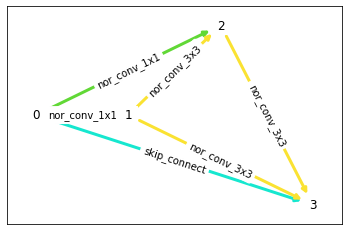

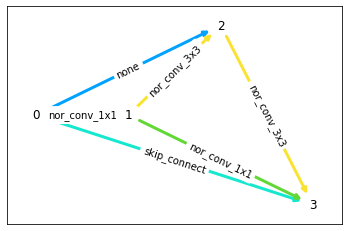

In [53]:
# get best 100 architectures (available with check relevant beside them)
data_type = 'test'
for prefix_type in ['max', 'final']:
    acc_type = prefix_type + '_acc'
    mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
    counter = 0
    for index in np.nditer(mean_sorted_ids[:1], order='C'):  # actually :top_N
        data_dict = all_data[index]
        architecture_string = data_dict[dataset_name]['200']['additional_information']['arch_str']
        edge_label, edge_colors = get_edge_labels_and_colors(architecture_string)
        plt.clf()
        nx.draw_networkx(G, pos=pos, labels=labels, arrows=True, node_shape="s", node_color="white",
                         edge_color=edge_colors, width=3)
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_label, font_color='black')
        # plt.title(f"Architecture {index} rank {counter} ({prefix_type.capitalize()} Accuracy)")
        counter += 1
        plt.savefig('best_arch.png', facecolor='w')
        plt.show()
        # for place in range(top_N):
        #     index = sort_ids_arr[place]
        #     data_dict = all_data[index]
# # analyse the architectures for

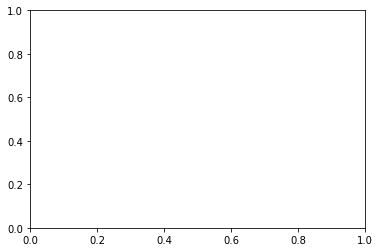

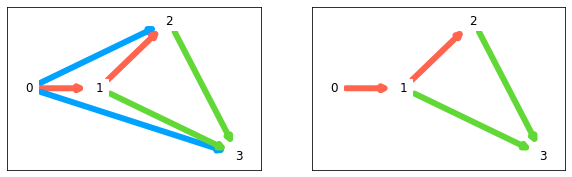

In [54]:
#export first, last, best and resNet arch for paper
arch_ids = [0, 15624, 13867, 11472, 5433]
for counter in range(len(arch_ids)):
    if counter == 0:
        name = 'first_arch'
    elif counter == 1:
        name = 'last_arch'
    elif counter == 2:
        name = 'best_arch'
    elif counter == 3:
        name = 'resNet_arch'
    elif counter == 4:
        name = 'bad_avg_conv_outlier'
    else:
        name = 'export'
    id = arch_ids[counter]
    architecture_string = get_architecture_string_by_index(id)
    # edge_dict = get_edge_dict(architecture_string)
    # edge_colors = get_color_array_for_edge_dict(edge_dict)
    plt.close()
    # nx.draw_networkx(G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color = edge_colors, width=6, font_size=20)
    # plt.savefig(name+'.svg')
    draw_graph_from_architecture_string(architecture_string, True, False, safeName=name + '.pdf')

In [55]:
# # draw top 1000 archs + reduce to relevant graph
# from pathlib import Path
Path(f"./best_and_worst_architectures/{data_set_prefix}").mkdir(parents=True, exist_ok=True)
# import networkx as nx
first_and_last_N = 1000
data_type = 'test'
if export_best_n_networks:
    for factor in [1,-1]:
        for prefix_type in ['max', 'final']:
            acc_type = prefix_type + '_acc'
            mean_sorted_ids = acc_dict_sorted_ids[acc_type]['mean'][data_type]
            counter = 0
            if factor > 0:
                start_rank = 1
                iter_list = mean_sorted_ids[:(first_and_last_N)],
            else:
                start_rank = len(all_data) - first_and_last_N + 1
                iter_list = mean_sorted_ids[(factor*first_and_last_N):]
            for index in np.nditer(iter_list, order='C'):  # actually :top_N
                data_dict = all_data[index]
                architecture_string = data_dict[dataset_name]['200']['additional_information']['arch_str']
                plt.close()
                acc_of_arch = acc_dict[acc_type]['mean'][data_type][index]
                rank = start_rank + counter
                title = f"{data_set_name_thesis}: Architecture {index}, rank {rank} ({acc_of_arch:.2f}% {prefix_type} test accuracy) + only relevant graph"
                draw_graph_from_architecture_string(architecture_string, True, False, title=title, safeName=f"./best_and_worst_architectures/{data_set_prefix}/{data_set_prefix}_{prefix_type}_{rank}_({index}).pdf")
                counter += 1